In [1]:
# Step 1 - Setup & Paths
BASE_DIR = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics"
DATA_XLSX = rf"{BASE_DIR}\pink_cockatoo_dataset.xlsx"
DATA_CSV  = rf"{BASE_DIR}\pink_cockatoo_dataset.csv"   # very likely this one
SPEC_DIR  = rf"{BASE_DIR}\spectrograms\Lophochroa_leadbeateri"

# Imports
import os, sys, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Base folder exists:", os.path.isdir(BASE_DIR))
print("Excel exists:", os.path.isfile(DATA_XLSX))
print("CSV exists:",   os.path.isfile(DATA_CSV))
print("Spectrogram dir exists:", os.path.isdir(SPEC_DIR))

# List files in folder to visually confirm
print("\nTop-level files in BASE_DIR:")
for f in os.listdir(BASE_DIR):
    print(" -", f)


Base folder exists: True
Excel exists: False
CSV exists: True
Spectrogram dir exists: True

Top-level files in BASE_DIR:
 - Audio file
 - metadata_recordings.csv
 - outputs
 - pink_cockatoo_dataset.csv
 - research papers
 - results
 - spectrograms
 - thesis_codes1.ipynb


In [3]:
# Step 2 - Data Load

def load_dataset(data_xlsx, data_csv):
    """
    Attempts to load the dataset from Excel first, then CSV.
    Returns (df, format_string).
    """
    
    if os.path.isfile(data_xlsx):
        try:
            import openpyxl  
            df = pd.read_excel(data_xlsx, engine="openpyxl")
            return df, "xlsx"
        except Exception as e:
            print("Excel read failed:", e)

     
    if os.path.isfile(data_csv):
        try:
            df = pd.read_csv(data_csv)
            return df, "csv"
        except Exception as e:
            print("CSV (comma) read failed:", e)
            
            try:
                df = pd.read_csv(data_csv, sep=";")
                return df, "csv(;)"
            except Exception as e2:
                print("CSV (semicolon) read failed:", e2)

    raise FileNotFoundError(
        "Could not find or read the dataset. "
        f"Tried:\n - {data_xlsx}\n - {data_csv}"
    )

df, fmt = load_dataset(DATA_XLSX, DATA_CSV)
print("Loaded dataset format:", fmt)
print("Shape:", df.shape)
display(df.head(3))
print("\nColumns:", list(df.columns))


Loaded dataset format: csv
Shape: (698, 20)


,recording_id,spectrogram_path,spectrogram_path.1,duration_sec,low_freq_hz,peak_freq_hz,high_freq_hz,peak_amplitude_db,snr_db,latitude,longitude,ibra_bioregion,habitat,date,time_local,season,temp_celcius,humidity,sex,age_class
0,1-audio-6346898344__chunk000,spectrograms/Lophochroa_leadbeateri/1-audio-63...,spectrograms/Lophochroa_leadbeateri/1-audio-63...,5,591.4,928.5,1146.3,55.4,19.6,-29.26319,134.23149,Finke,Spinifex grassland,26/01/2023,7:59,Summer,19.7,27.1,Male,Adult
1,1-audio-6346898344__chunk001,spectrograms/Lophochroa_leadbeateri/1-audio-63...,spectrograms/Lophochroa_leadbeateri/1-audio-63...,5,1007.5,1211.7,1677.1,66.6,13.5,-20.34459,125.17441,Finke,Spinifex grassland,26/01/2023,8:59,Summer,19.7,27.1,Male,Adult
2,1-audio-6346898344__chunk002,spectrograms/Lophochroa_leadbeateri/1-audio-63...,spectrograms/Lophochroa_leadbeateri/1-audio-63...,5,1350.5,1571.6,1838.2,73.1,12.0,-20.45470,127.58602,Finke,Spinifex grassland,26/01/2023,9:59,Summer,19.7,27.1,Male,Adult



Columns: ['recording_id', 'spectrogram_path', 'spectrogram_path.1', 'duration_sec', 'low_freq_hz', 'peak_freq_hz', 'high_freq_hz', 'peak_amplitude_db', 'snr_db', 'latitude', 'longitude', 'ibra_bioregion', 'habitat', 'date', 'time_local', 'season', 'temp_celcius', 'humidity', 'sex', 'age_class']


In [5]:
# Step 3 - Column Sanity and Lightweight Harmonization

CAND_ID      = [c for c in df.columns if c.lower() in ("recording_id","id","clip_id")]
CAND_SPEC    = [c for c in df.columns if "spectrogram" in c.lower() or "spec_path" in c.lower() or c.lower()=="file_path"]
CAND_LAT     = [c for c in df.columns if c.lower() in ("lat","latitude")]
CAND_LON     = [c for c in df.columns if c.lower() in ("lon","longitude","long")]
CAND_DATE    = [c for c in df.columns if c.lower() in ("date","recording_date")]
CAND_TIME    = [c for c in df.columns if "time" in c.lower()]
CAND_REGION  = [c for c in df.columns if "ibra" in c.lower() or "bioregion" in c.lower()]
CAND_SEASON  = [c for c in df.columns if c.lower()=="season"]
CAND_TEMP    = [c for c in df.columns if "temp" in c.lower()]
CAND_HUM     = [c for c in df.columns if "humid" in c.lower()]

# Acoustic numeric features 
acoustic_cols_pref = [
    "duration_s","duration_sec","low_freq_hz","peak_freq_hz","high_freq_hz",
    "peak_amplitude_db","snr_db","bandwidth_hz"
]

# Resolve canonical names
def pick(col_list, default=None):
    return col_list[0] if len(col_list)>0 else default

col_id      = pick(CAND_ID)
col_spec    = pick(CAND_SPEC)
col_lat     = pick(CAND_LAT)
col_lon     = pick(CAND_LON)
col_date    = pick(CAND_DATE)
col_time    = pick(CAND_TIME)
col_region  = pick(CAND_REGION)
col_season  = pick(CAND_SEASON) or "season"
col_temp    = pick(CAND_TEMP)
col_hum     = pick(CAND_HUM)

print("Resolved columns:")
print(" recording_id:", col_id)
print(" spectrogram_path:", col_spec)
print(" latitude:", col_lat, " longitude:", col_lon)
print(" date:", col_date, " time:", col_time)
print(" region:", col_region, " season:", col_season)
print(" temp:", col_temp, " humidity:", col_hum)

if col_date or col_time:
    
    dt_series = None
    if col_date and col_time:
        dt_series = pd.to_datetime(df[col_date].astype(str) + " " + df[col_time].astype(str), errors="coerce", dayfirst=True)
    elif col_date:
        dt_series = pd.to_datetime(df[col_date], errors="coerce", dayfirst=True)
    elif col_time:
        dt_series = pd.to_datetime(df[col_time], errors="coerce", format="%H:%M")
    df["timestamp"] = dt_series
else:
    df["timestamp"] = pd.NaT


df["hour"]  = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.month

# Season mapping 
if col_season not in df.columns:
    def to_season(m):
        if pd.isna(m): return np.nan
        m = int(m)
        if m in (12,1,2): return "Summer"
        if m in (3,4,5):  return "Autumn"
        if m in (6,7,8):  return "Winter"
        return "Spring"
    df["season"] = df["month"].map(to_season)
else:
    
    if col_season != "season":
        df["season"] = df[col_season]

# Build full spectrogram path from relative paths 
if col_spec and df[col_spec].notna().any():
    def resolve_spec(p):
        p = str(p)
        
        if os.path.isabs(p):
            return p
        
        p = p.lstrip(r"\/")
        return os.path.join(SPEC_DIR, os.path.basename(p)) if os.path.isfile(os.path.join(SPEC_DIR, os.path.basename(p))) else os.path.join(SPEC_DIR, p)
    df["spec_fullpath"] = df[col_spec].apply(resolve_spec)
else:
    df["spec_fullpath"] = np.nan

# Collect acoustic feature columns 
acoustic_cols = [c for c in acoustic_cols_pref if c in df.columns]
print("\nAcoustic feature columns in your file:", acoustic_cols)

# rows for key analyses
key_numeric = [c for c in acoustic_cols if df[c].dtype != "O"]
df_num = df.dropna(subset=key_numeric)
print("Rows with complete numeric acoustic features:", df_num.shape[0], "of", df.shape[0])


Resolved columns:
 recording_id: recording_id
 spectrogram_path: spectrogram_path
 latitude: latitude  longitude: longitude
 date: date  time: time_local
 region: ibra_bioregion  season: season
 temp: temp_celcius  humidity: humidity

Acoustic feature columns in your file: ['duration_sec', 'low_freq_hz', 'peak_freq_hz', 'high_freq_hz', 'peak_amplitude_db', 'snr_db']
Rows with complete numeric acoustic features: 698 of 698


,count,mean,std,min,25%,50%,75%,max
duration_sec,698.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
low_freq_hz,698.0,988.043983,656.094367,80.0,520.5,872.0,1325.1,2766.2
peak_freq_hz,698.0,1299.170487,704.359751,318.1,774.0,1165.4,1575.4,3152.1
high_freq_hz,698.0,1926.278223,734.858081,960.1,1406.2,1738.8,2134.2,3861.7
peak_amplitude_db,698.0,69.961748,12.583165,45.4,61.2,67.2,78.5,99.6
snr_db,698.0,15.881519,4.138543,8.0,12.3,15.6,19.5,24.2


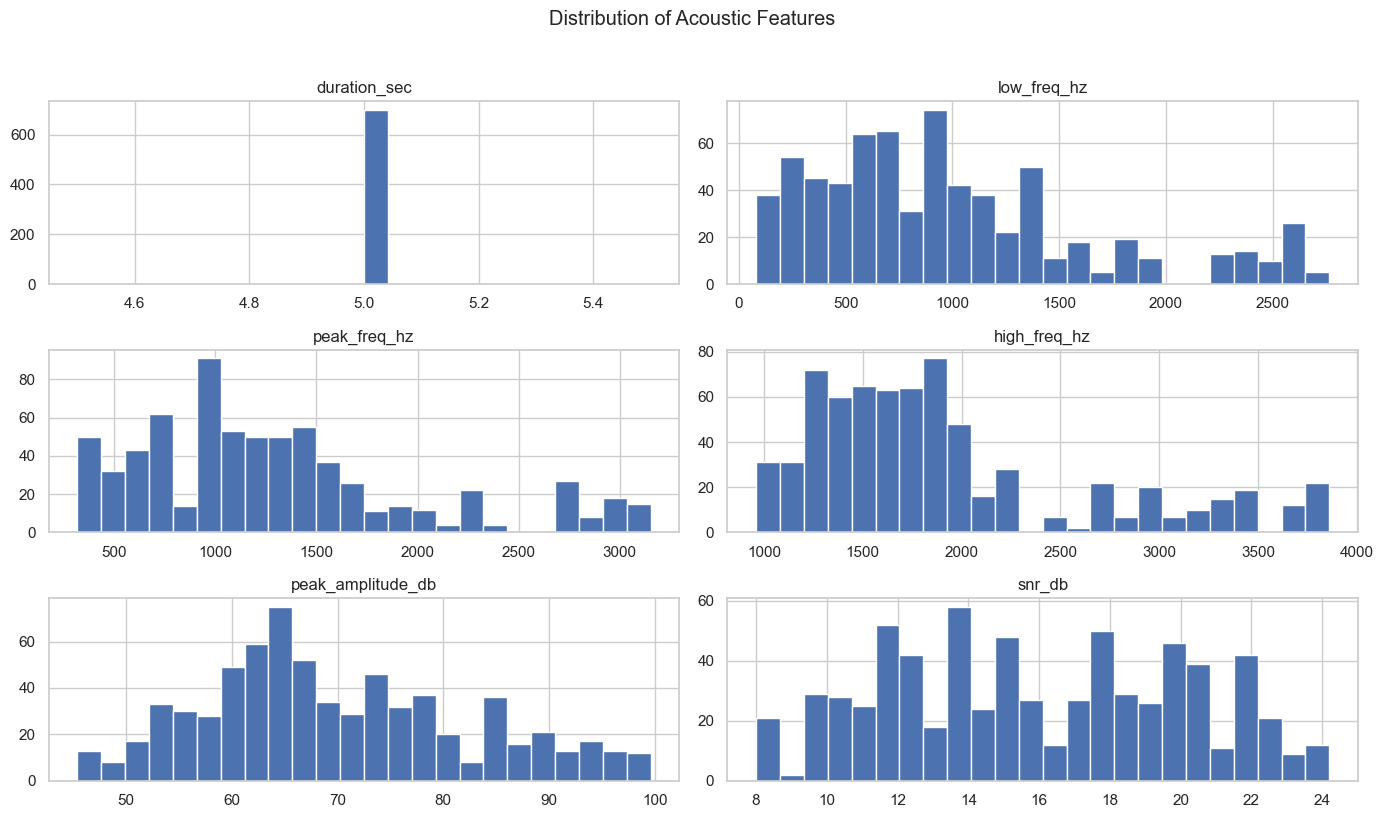

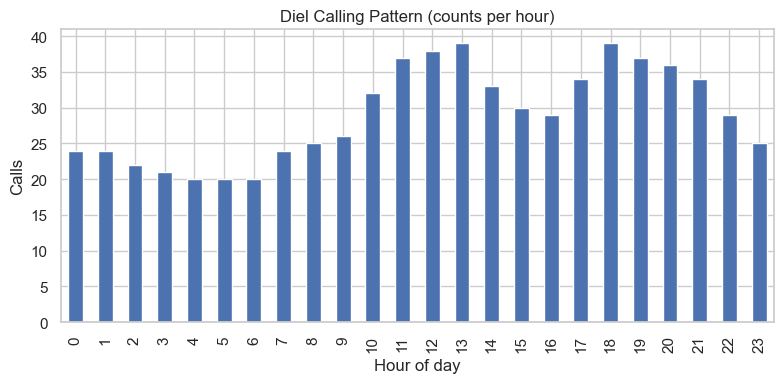

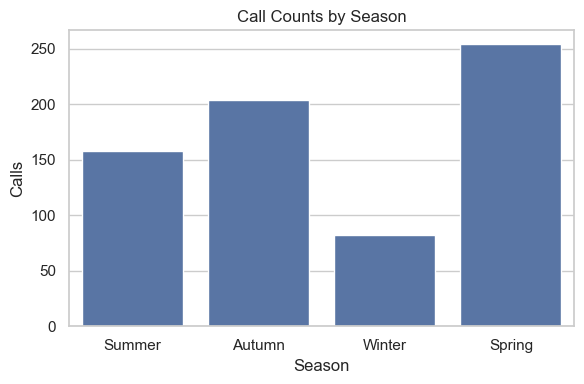

In [7]:
# Step 4 - Descriptive Statistics & Temporal Patterns

import os
import seaborn as sns
import matplotlib.pyplot as plt

# Directory to save figures
save_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(save_dir, exist_ok=True)

sns.set(style="whitegrid", context="notebook")

# Summary stats
display(df_num[acoustic_cols].describe().T)

# Histograms
ax = df_num[acoustic_cols].hist(figsize=(14,8), bins=24)
plt.suptitle("Distribution of Acoustic Features", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "distribution_acoustic_features.png"),
            dpi=300, bbox_inches="tight")
plt.show()

# Diel cycle (hourly-day calling)
if df["hour"].notna().any():
    plt.figure(figsize=(8,4))
    df.groupby("hour").size().plot(kind="bar")
    plt.title("Diel Calling Pattern (counts per hour)")
    plt.xlabel("Hour of day")
    plt.ylabel("Calls")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "diel_calling_pattern.png"),
                dpi=300, bbox_inches="tight")
    plt.show()

# Seasonal counts
if "season" in df.columns:
    order = ["Summer","Autumn","Winter","Spring"]
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="season",
                  order=[s for s in order if s in df["season"].unique()])
    plt.title("Call Counts by Season")
    plt.xlabel("Season"); plt.ylabel("Calls")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "call_counts_by_season.png"),
                dpi=300, bbox_inches="tight")
    plt.show()


PCA variance explained: 0.8954742978002204


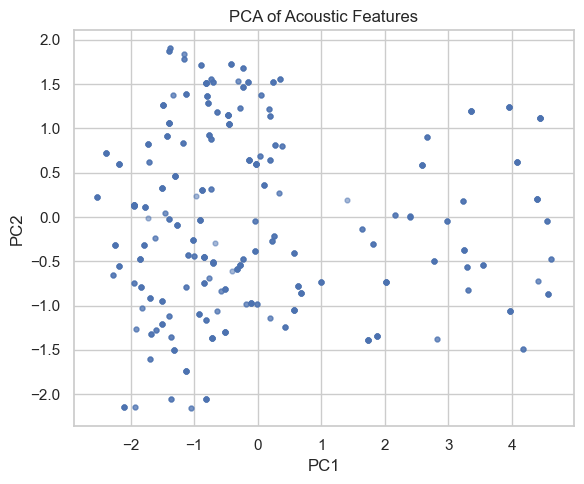

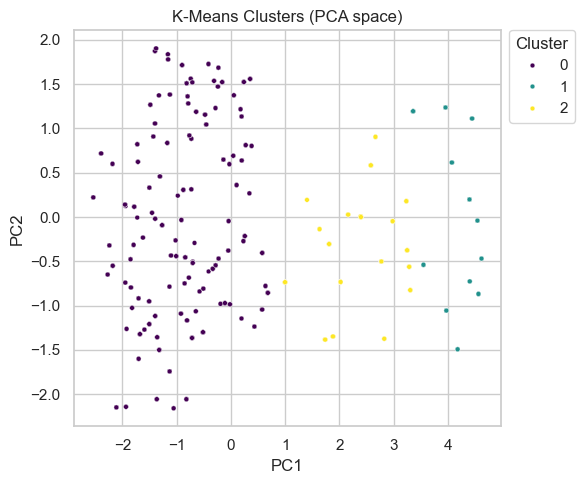

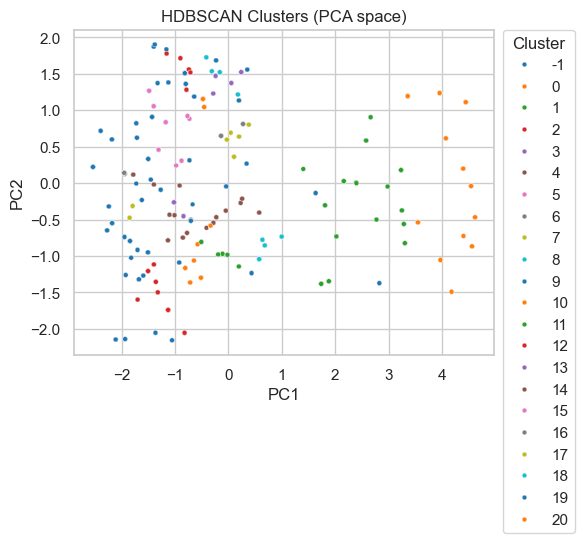

,duration_sec,low_freq_hz,peak_freq_hz,high_freq_hz,peak_amplitude_db,snr_db
0,5.000000,707.064469,993.425458,1589.109890,64.730403,16.368132
1,5.000000,2473.851471,2893.686765,3592.052941,87.258824,15.013235
2,5.000000,1611.614286,1995.714286,2769.388095,89.963095,13.421429


In [9]:
# Step 5 - Clustering (PCA and K-Means + HDBSCAN) for Dialect-like Groupings

!pip install hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hdbscan

X = df_num[acoustic_cols].values
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

# PCA (2D for visualization)
pca = PCA(n_components=2).fit(Xz)
Xp = pca.transform(Xz)
print("PCA variance explained:", pca.explained_variance_ratio_.sum())

# Plot PCA scatter
plt.figure(figsize=(6,5))
plt.scatter(Xp[:,0], Xp[:,1], s=12, alpha=0.5)
plt.title("PCA of Acoustic Features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# K-Means (k=3)
km = KMeans(n_clusters=3, random_state=42).fit(Xz)
df_num["cluster_km"] = km.labels_

plt.figure(figsize=(6,5))
ax = sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df_num["cluster_km"], palette="viridis", s=12)
plt.title("K-Means Clusters (PCA space)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gcf().subplots_adjust(right=0.78)  # leave space for legend
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout(); plt.show()

# HDBSCAN (density-based)
hdb = hdbscan.HDBSCAN(min_cluster_size=12, min_samples=8).fit(Xz)
df_num["cluster_hdb"] = hdb.labels_

plt.figure(figsize=(6,5))
ax = sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df_num["cluster_hdb"], palette="tab10", s=12)
plt.title("HDBSCAN Clusters (PCA space)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gcf().subplots_adjust(right=0.78)  # leave space for legend
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout(); plt.show()

# Centroids (K-Means) in original scale
centroids = pd.DataFrame(scaler.inverse_transform(km.cluster_centers_), columns=acoustic_cols)
display(centroids.style.set_caption("K-Means centroids (original units)"))


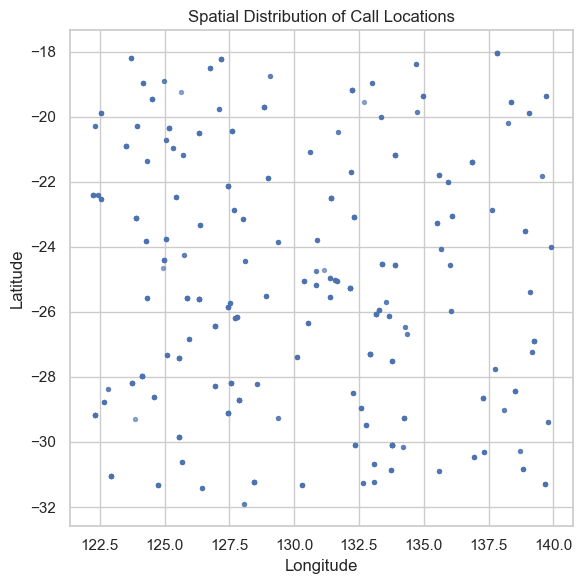

Approx. NT calls: 173


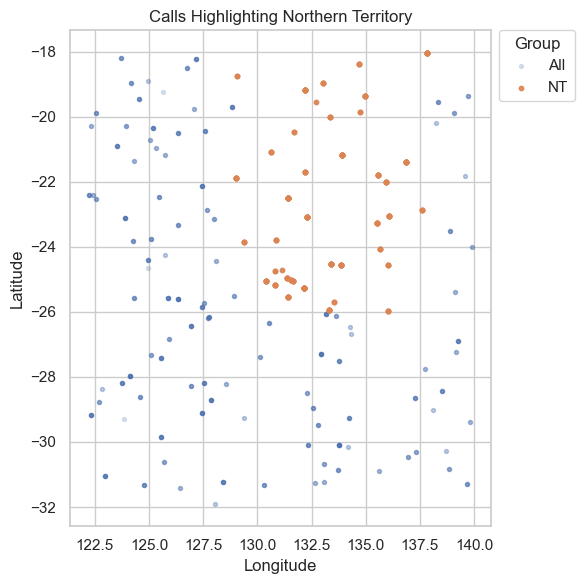

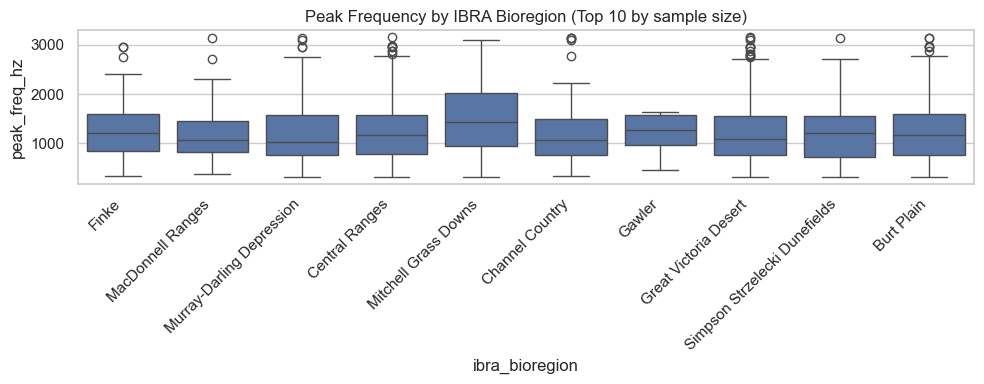

In [11]:
# Step 6- Spatial Mapping 

if col_lat and col_lon:
    plt.figure(figsize=(6,6))
    plt.scatter(df[col_lon], df[col_lat], s=8, alpha=0.6)
    plt.title("Spatial Distribution of Call Locations")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()

    # Approx NT bounding box (lon 129–138 E, lat -26 to -10)
    nt_mask = (df[col_lon].between(129,138)) & (df[col_lat].between(-26,-10))
    print("Approx. NT calls:", nt_mask.sum())

    plt.figure(figsize=(6,6))
    plt.scatter(df[col_lon], df[col_lat], s=8, alpha=0.2, label="All")
    plt.scatter(df.loc[nt_mask,col_lon], df.loc[nt_mask,col_lat], s=10, alpha=0.9, label="NT")
    plt.title("Calls Highlighting Northern Territory")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.gcf().subplots_adjust(right=0.78)
    plt.legend(title="Group", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout(); plt.show()

# Boxplot of peak frequency by IBRA bioregion 
if col_region and "peak_freq_hz" in df.columns:
    top_regions = df[col_region].value_counts().head(10).index.tolist()
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df[df[col_region].isin(top_regions)], x=col_region, y="peak_freq_hz")
    plt.xticks(rotation=45, ha="right")
    plt.title("Peak Frequency by IBRA Bioregion (Top 10 by sample size)")
    plt.tight_layout(); plt.show()


Images found for training: 698


,spec_fullpath,label
0,C:\Users\rahma\Downloads\AI-Driven Bioacoustic...,Finke
1,C:\Users\rahma\Downloads\AI-Driven Bioacoustic...,Finke
2,C:\Users\rahma\Downloads\AI-Driven Bioacoustic...,Finke


Found 558 validated image filenames belonging to 11 classes.
Found 140 validated image filenames belonging to 11 classes.
Detected classes: {'Burt Plain': 0, 'Central Ranges': 1, 'Channel Country': 2, 'Finke': 3, 'Gawler': 4, 'Great Victoria Desert': 5, 'MacDonnell Ranges': 6, 'Mitchell Grass Downs': 7, 'Murray-Darling Depression': 8, 'Simpson Strzelecki Dunefields': 9, 'Tanami': 10}
Class weights: {0: 0.5339712918660288, 1: 0.5636363636363636, 2: 0.9946524064171123, 3: 1.2077922077922079, 4: 4.2272727272727275, 5: 0.6503496503496503, 6: 1.3006993006993006, 7: 1.4919786096256684, 8: 0.757123473541384, 9: 1.268181818181818, 10: 5.072727272727272}


Model: "pink_cockatoo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ penultimate_dense (Dense)            │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,059 (12.61 MB)

 Trainable params: 3,306,059 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0783 - loss: 2.5634 - val_accuracy: 0.1643 - val_loss: 2.3385
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 909ms/step - accuracy: 0.1737 - loss: 2.3295 - val_accuracy: 0.1714 - val_loss: 2.0990
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 844ms/step - accuracy: 0.2692 - loss: 2.1088 - val_accuracy: 0.2786 - val_loss: 2.0173
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.3152 - loss: 1.9107 - val_accuracy: 0.4071 - val_loss: 1.8239
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 825ms/step - accuracy: 0.3735 - loss: 1.8681 - val_accuracy: 0.4071 - val_loss: 1.7162
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.5036 - loss: 1.5266 - val_accuracy: 0.4000 - val_loss: 1.6870
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 810ms/step - accuracy: 0.4922 - loss: 1.4866 - val_accuracy: 0.4000 - val_loss: 1.7122
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 829ms/step - accuracy: 0.5291 - loss: 1.2549 - val_accurac

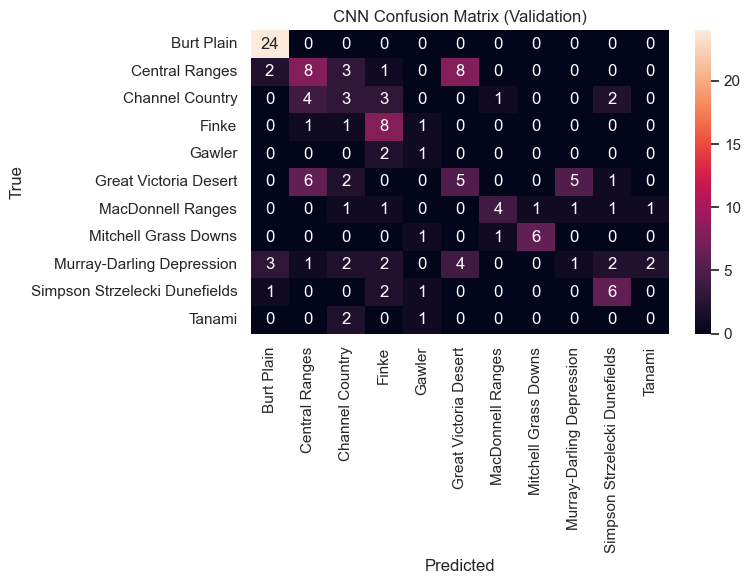

In [13]:
# STEP 7 — CNN TRAINING
# Functional API  + sample-weighted batches

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# 6.1 Choose label column

if "call_type" in df.columns:
    label_col = "call_type"
elif "ibra_bioregion" in df.columns:
    label_col = "ibra_bioregion"
elif "IBRA_region" in df.columns:
    label_col = "IBRA_region"
elif "cluster_km" in df.columns:
    label_col = "cluster_km"
else:
    raise ValueError("No usable label column found. Add 'call_type' or 'ibra_bioregion' (or 'cluster_km').")


if "spec_fullpath" not in df.columns:
    raise ValueError("Missing 'spec_fullpath' column. Ensure earlier steps built absolute paths to PNG spectrograms.")

df_img = df.dropna(subset=["spec_fullpath"]).copy()
df_img = df_img[df_img["spec_fullpath"].apply(os.path.isfile)].copy()
df_img["label"] = df_img[label_col].astype(str)

print("Images found for training:", len(df_img))
display(df_img[["spec_fullpath","label"]].head(3))


# 6.2 Train/Val split

train_df, val_df = train_test_split(
    df_img, test_size=0.2, random_state=42, stratify=df_img["label"]
)


IMG_SIZE = (128,128)
BATCH    = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col="spec_fullpath", y_col="label",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH, shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df, x_col="spec_fullpath", y_col="label",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH, shuffle=False
)

# Class dictionary (reused by CRNN and later analysis)
class_indices = train_gen.class_indices
n_classes = len(class_indices)
print("Detected classes:", class_indices)


# 6.4 weights for imbalance 

y_idx = np.array([class_indices[y] for y in train_df["label"]])
cw = compute_class_weight(class_weight="balanced", classes=np.arange(n_classes), y=y_idx)
class_weights = {i: w for i, w in enumerate(cw)}
idx_to_w = np.array([class_weights[i] for i in range(n_classes)], dtype="float32")
print("Class weights:", class_weights)

def weighted_gen(gen):
    """Wrap a Keras iterator to also yield sample_weight per batch."""
    while True:
        x, y = next(gen)                      # y is one-hot
        y_idx_batch = y.argmax(axis=1)
        sw = idx_to_w[y_idx_batch]            # (B,)
        yield (x, y, sw)

train_gen_w = weighted_gen(train_gen)
steps_per_epoch = int(np.ceil(train_gen.n / BATCH))


# 6.5 Build CNN (Functional API with explicit Input)

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = tf.keras.layers.Conv2D(32, (3,3), activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu", name="penultimate_dense")(x)  # named for Step 16
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

model_cnn = tf.keras.Model(inputs=inputs, outputs=outputs, name="pink_cockatoo_cnn")
model_cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_cnn.summary()


# 6.6 Train (with early stopping)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history_cnn = model_cnn.fit(
    train_gen_w,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,         # val labels are fine without weights
    epochs=50,
    callbacks=[es],
    verbose=1
)


# 6.7 Evaluate 

val_probs = model_cnn.predict(val_gen, verbose=0)
val_pred  = val_probs.argmax(axis=1)
val_true  = val_gen.classes
labels    = list(class_indices.keys())

print("\nCNN Classification report (validation):\n")
print(classification_report(val_true, val_pred, target_names=labels, digits=3))

cm = confusion_matrix(val_true, val_pred, labels=range(len(labels)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("CNN Confusion Matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()




In [186]:
# Step 8: CRNN Training (Reuse Class Indices)


from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Reuse class_indices from CNN
label_to_idx = class_indices

# Map labels
df_img["label_idx"] = df_img["label"].map(label_to_idx)
df_img = df_img.dropna(subset=["label_idx"])

# Train/val split
train_df, val_df = train_test_split(df_img, test_size=0.2, stratify=df_img["label_idx"], random_state=42)

import cv2, random

def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128,128))
    return img.astype("float32")/255.0

def crnn_data_generator(df, batch_size=32):
    while True:
        batch = df.sample(n=batch_size)
        X, y = [], []
        for _, row in batch.iterrows():
            img = load_image(row["spec_fullpath"])
            X.append(img)
            y.append(row["label_idx"])
        X = np.array(X)
        y = to_categorical(y, num_classes=n_classes)
        yield X, y

train_gen_crnn = crnn_data_generator(train_df, batch_size=32)
val_gen_crnn   = crnn_data_generator(val_df, batch_size=32)

steps_train = len(train_df)//32
steps_val   = len(val_df)//32

# CRNN architecture
inputs = tf.keras.Input(shape=(128,128,3))
x = tf.keras.layers.Conv2D(32,(3,3),activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Reshape((x.shape[1], x.shape[2]*x.shape[3]))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

model_crnn = tf.keras.Model(inputs, outputs)
model_crnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_crnn.summary()

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

hist_crnn = model_crnn.fit(
    train_gen_crnn,
    steps_per_epoch=steps_train,
    validation_data=val_gen_crnn,
    validation_steps=steps_val,
    epochs=20,
    callbacks=[es]
)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 30, 1920)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 30, 128)             │         762,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 874,443 (3.34 MB)

 Trainable params: 874,443 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1115 - loss: 2.3685 - val_accuracy: 0.2812 - val_loss: 2.2035
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step - accuracy: 0.2447 - loss: 2.2058 - val_accuracy: 0.2344 - val_loss: 2.0759
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 753ms/step - accuracy: 0.2863 - loss: 2.0369 - val_accuracy: 0.3125 - val_loss: 1.8666
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.3162 - loss: 1.8446 - val_accuracy: 0.3125 - val_loss: 1.7984
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 776ms/step - accuracy: 0.3682 - loss: 1.7403 - val_accuracy: 0.4453 - val_loss: 1.6255
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 775ms/step - accuracy: 0.4120 - loss: 1.6415 - val_accuracy: 0.3672 - val_loss: 1.6128
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 763ms/step - accuracy: 0.4446 - loss: 1.5565 - val_accuracy: 0.4609 - val_loss: 1.5939
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 771ms/step - accuracy: 0.4860 - loss: 1.4266 - val_accurac

In [190]:
# Step 8 — Save models

import os

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

model_cnn.save(os.path.join(out_dir, "cnn_model.h5"))
model_crnn.save(os.path.join(out_dir, "crnn_model.h5"))
df_img.to_csv(os.path.join(out_dir, "processed_dataset.csv"), index=False)

print("Models and dataset saved in:", out_dir)


Models and dataset saved in: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results


In [192]:

# STEP 9 — Full-Data Inferences 
# CNN

import numpy as np
import pandas as pd
import os
from PIL import Image

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

def img_to_array(path, target=(128,128)):
    im = Image.open(path).convert("RGB").resize(target)
    return np.asarray(im, dtype=np.float32)/255.0

paths = df_img["spec_fullpath"].tolist()
BATCH = 128

cnn_probs_parts = []
for i in range(0, len(paths), BATCH):
    batch_paths = paths[i:i+BATCH]
    Xb = np.stack([img_to_array(p) for p in batch_paths], axis=0)   # (B,128,128,3)
    pb = model_cnn.predict(Xb, verbose=0)
    cnn_probs_parts.append(pb)
cnn_probs = np.vstack(cnn_probs_parts)
cnn_pred_idx = cnn_probs.argmax(axis=1)

idx_to_label = {v:k for k,v in class_indices.items()}
df_img["cnn_pred"] = [idx_to_label[i] for i in cnn_pred_idx]
df_img["cnn_conf"] = cnn_probs.max(axis=1)

# CRNN 
crnn_probs_parts = []
for i in range(0, len(paths), BATCH):
    batch_paths = paths[i:i+BATCH]
    Xb = np.stack([img_to_array(p) for p in batch_paths], axis=0)
    pb = model_crnn.predict(Xb, verbose=0)
    crnn_probs_parts.append(pb)
crnn_probs = np.vstack(crnn_probs_parts)
crnn_pred_idx = crnn_probs.argmax(axis=1)

df_img["crnn_pred"] = [idx_to_label[i] for i in crnn_pred_idx]
df_img["crnn_conf"] = crnn_probs.max(axis=1)

pred_csv = os.path.join(out_dir, "predictions_full_dataset.csv")
df_img.to_csv(pred_csv, index=False)
print("Saved predictions table ->", pred_csv)


Saved predictions table -> C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\predictions_full_dataset.csv


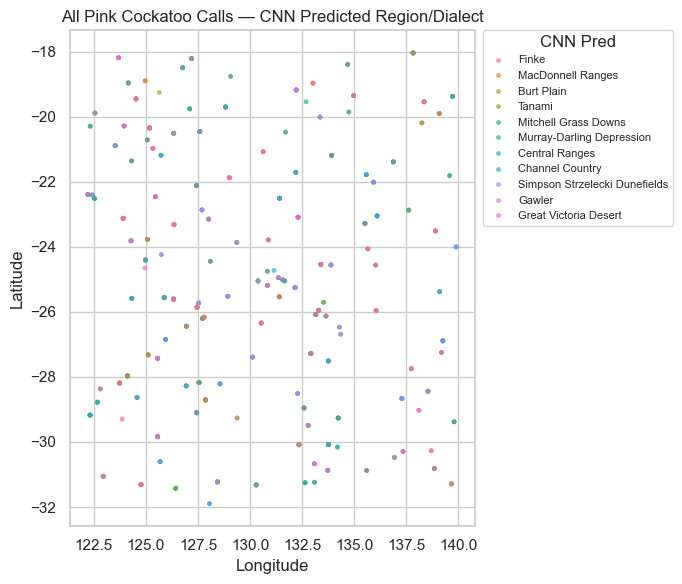

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\map_cnn_pred_scatter.png
Approx NT records: 173


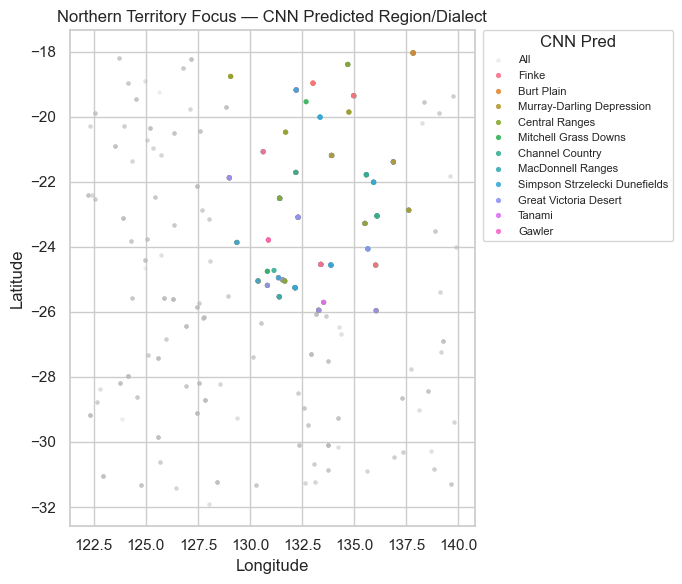

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\map_nt_cnn_pred_scatter.png


In [257]:
# Step 10 — Spatial mapping & NT emphasis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# detecting lat/lon columns from dataset
lat_col = None
lon_col = None
for c in df_img.columns:
    lc = c.lower()
    if lc in ("lat","latitude"): lat_col = c
    if lc in ("lon","long","longitude"): lon_col = c

if lat_col and lon_col:
    # All calls colored by CNN-predicted dialect
    plt.figure(figsize=(7,6))
    ax = sns.scatterplot(
        data=df_img.dropna(subset=[lat_col, lon_col]),
        x=lon_col, y=lat_col,
        hue="cnn_pred", s=12, alpha=0.7, linewidth=0
    )
    plt.title("All Pink Cockatoo Calls — CNN Predicted Region/Dialect")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")

    # move legend outside (right)
    plt.gcf().subplots_adjust(right=0.78)
    ax.legend(title="CNN Pred", bbox_to_anchor=(1.02, 1), loc="upper left",
              borderaxespad=0., fontsize=8)

    plt.tight_layout()
    fig1 = os.path.join(out_dir, "map_cnn_pred_scatter.png")
    plt.savefig(fig1, dpi=250); plt.show()
    print("Saved:", fig1)

    # NT emphasis (bounding box lon 129–138 E, lat −26 to −10)
    nt_mask = df_img[lon_col].between(129, 138) & df_img[lat_col].between(-26, -10)
    df_nt = df_img.loc[nt_mask].copy()
    print("Approx NT records:", df_nt.shape[0])

    if not df_nt.empty:
        plt.figure(figsize=(7,6))
        sns.scatterplot(
            data=df_img.dropna(subset=[lat_col, lon_col]),
            x=lon_col, y=lat_col,
            color="#bbbbbb", s=10, alpha=0.25, linewidth=0, label="All"
        )
        ax2 = sns.scatterplot(
            data=df_nt.dropna(subset=[lat_col, lon_col]),
            x=lon_col, y=lat_col,
            hue="cnn_pred", s=14, alpha=0.9, linewidth=0
        )
        plt.title("Northern Territory Focus — CNN Predicted Region/Dialect")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")

        # move legend outside (right)
        plt.gcf().subplots_adjust(right=0.78)
        ax2.legend(title="CNN Pred", bbox_to_anchor=(1.02, 1), loc="upper left",
                   borderaxespad=0., fontsize=8)

        plt.tight_layout()
        fig2 = os.path.join(out_dir, "map_nt_cnn_pred_scatter.png")
        plt.savefig(fig2, dpi=250); plt.show()
        print("Saved:", fig2)
else:
    print("Latitude/Longitude columns not found — skipped spatial maps.")


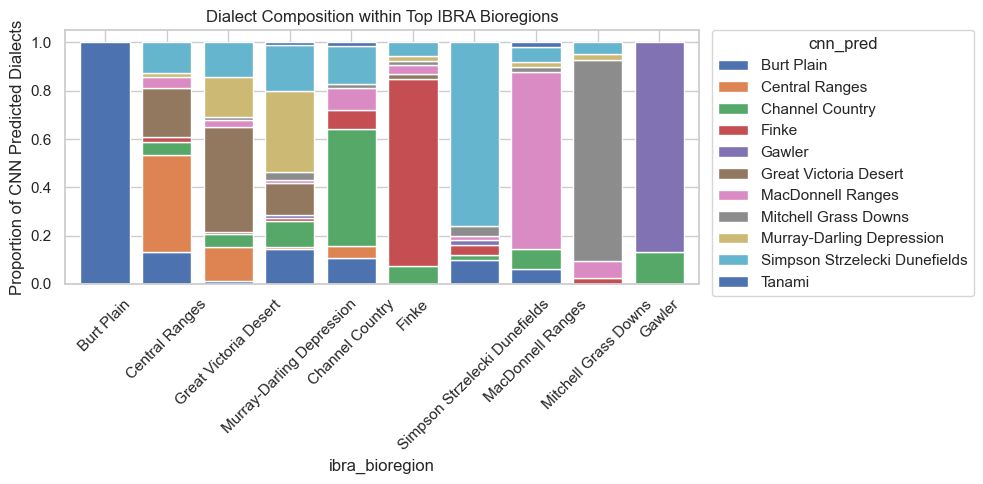

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\region_dialect_stackedbar.png


In [196]:
# Step 11 — Regional distributions & Dialect composition 

region_col = None
for c in ["ibra_bioregion","IBRA_region","region","Region"]:
    if c in df_img.columns:
        region_col = c
        break

if region_col is not None:
    # Top regions by sample size
    top_regions = df_img[region_col].value_counts().head(10).index.tolist()
    df_top = df_img[df_img[region_col].isin(top_regions)].copy()

    # Stacked bar: within each true region, composition of CNN predicted labels
    comp = (
        df_top
        .groupby([region_col, "cnn_pred"])
        .size().reset_index(name="count")
    )
    total = comp.groupby(region_col)["count"].transform("sum")
    comp["prop"] = comp["count"] / total

    # Plot: stacked bar with legend 
    pivot = comp.pivot(index=region_col, columns="cnn_pred", values="prop").fillna(0)

    fig, ax = plt.subplots(figsize=(10, 5))
    pivot.loc[top_regions].plot(kind="bar", stacked=True, ax=ax, width=0.8)

    ax.set_ylabel("Proportion of CNN Predicted Dialects")
    ax.set_title("Dialect Composition within Top IBRA Bioregions")
    ax.tick_params(axis="x", rotation=45)
    
    # leave space on the right so legend fits
    fig.subplots_adjust(right=0.78)
    
    ax.legend(title="cnn_pred", bbox_to_anchor=(1.02, 1), loc="upper left",
              borderaxespad=0., ncol=1, frameon=True)

    fig.tight_layout()
    fig3 = os.path.join(out_dir, "region_dialect_stackedbar.png")
    fig.savefig(fig3, dpi=250)
    plt.show()
    print("Saved:", fig3)

    # 11.2 Confusion (if label_col == region_col, i.e., we used region as training label)
    
    if "label" in df_img.columns and region_col == "label":
        from sklearn.metrics import confusion_matrix
        lab_order = list(class_indices.keys())
        cm = confusion_matrix(
            df_img["label"].map(class_indices),
            df_img["cnn_pred"].map(class_indices),
            labels=range(len(lab_order))
        )

        plt.figure(figsize=(8, 7))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=lab_order, yticklabels=lab_order)
        plt.title("Region vs CNN Predicted Region — Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        fig4 = os.path.join(out_dir, "region_confusion_cnn.png")
        plt.savefig(fig4, dpi=250); plt.show()
        print("Saved:", fig4)
else:
    print("Region column not found — skipped regional composition.")


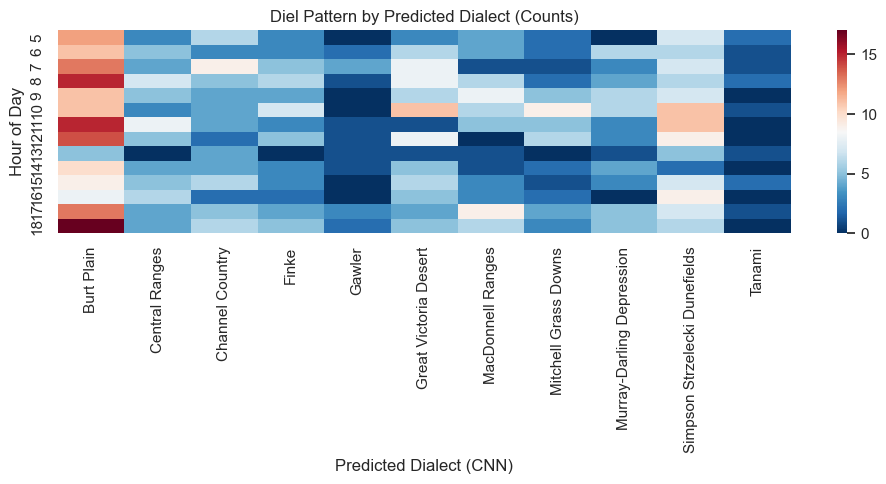

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\diel_heatmap_cnn.png


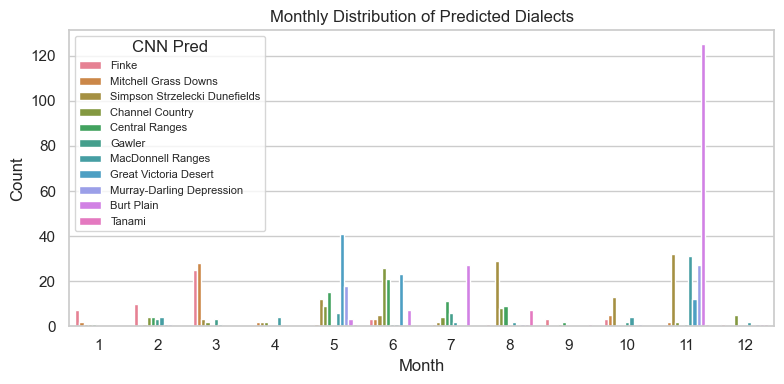

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\seasonal_counts_cnn.png


In [198]:
# Step 12 — Temporal patterns of predicted dialects (diel & seasonal)

# Ensuring time columns
if "timestamp" in df_img.columns:
    df_img["hour"]  = df_img["timestamp"].dt.hour
    df_img["month"] = df_img["timestamp"].dt.month

# Heatmap: Hour-of-day × CNN predicted dialect (counts)
if "hour" in df_img.columns:
    diel = (df_img.dropna(subset=["hour"])
                  .groupby(["hour","cnn_pred"])
                  .size().reset_index(name="count"))
    diel_pivot = diel.pivot(index="hour", columns="cnn_pred", values="count").fillna(0)
    plt.figure(figsize=(10,5))
    sns.heatmap(diel_pivot, annot=False, cmap="RdBu_r")
    plt.title("Diel Pattern by Predicted Dialect (Counts)")
    plt.ylabel("Hour of Day"); plt.xlabel("Predicted Dialect (CNN)")
    plt.tight_layout()
    fig5 = os.path.join(out_dir, "diel_heatmap_cnn.png"); plt.savefig(fig5, dpi=250); plt.show()
    print("Saved:", fig5)

# Seasonal distribution of predictions
if "month" in df_img.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_img, x="month", hue="cnn_pred")
    plt.title("Monthly Distribution of Predicted Dialects")
    plt.xlabel("Month"); plt.ylabel("Count")
    plt.legend(loc="best", fontsize=8, title="CNN Pred")
    plt.tight_layout()
    fig6 = os.path.join(out_dir, "seasonal_counts_cnn.png"); plt.savefig(fig6, dpi=250); plt.show()
    print("Saved:", fig6)


NT rows for temporal analysis: 173


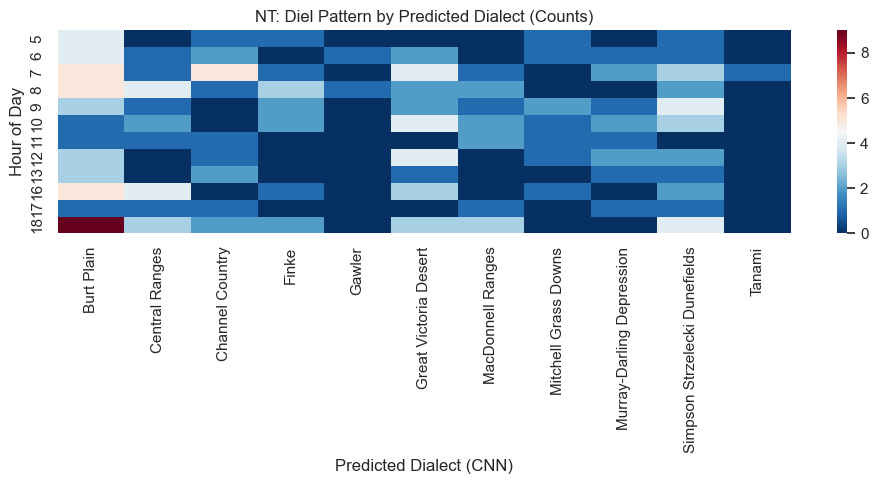

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\nt_diel_heatmap_cnn.png


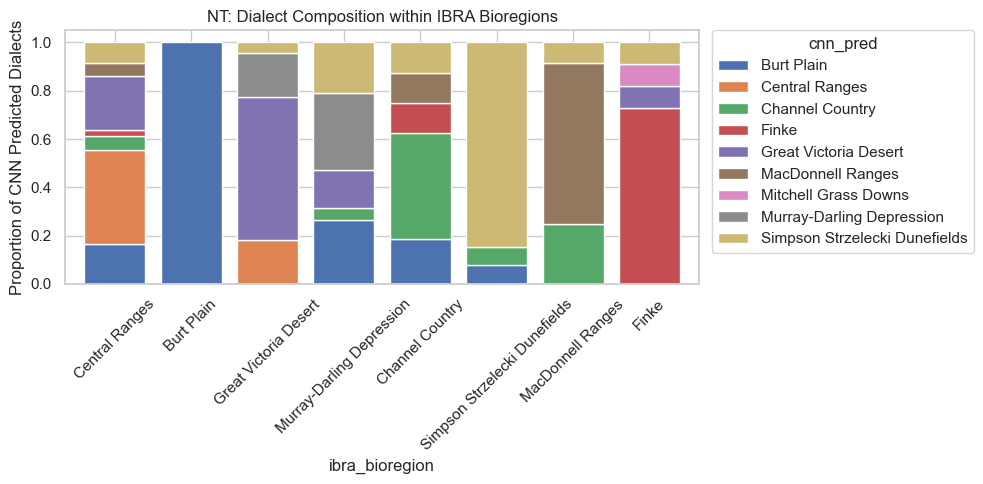

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\nt_region_dialect_stackedbar.png


In [200]:
# STEP 13 — Northern Territory (NT) specific temporal & regional views

if lat_col and lon_col and "hour" in df_img.columns:
    nt_mask = df_img[lon_col].between(129, 138) & df_img[lat_col].between(-26, -10)
    df_nt = df_img.loc[nt_mask].copy()
    print("NT rows for temporal analysis:", df_nt.shape[0])

    if not df_nt.empty:
        # NT diel heatmap
        diel_nt = (df_nt.dropna(subset=["hour"])
                        .groupby(["hour","cnn_pred"])
                        .size().reset_index(name="count"))
        diel_nt_pivot = diel_nt.pivot(index="hour", columns="cnn_pred", values="count").fillna(0)

        plt.figure(figsize=(10,5))
        sns.heatmap(diel_nt_pivot, annot=False, cmap="RdBu_r")
        plt.title("NT: Diel Pattern by Predicted Dialect (Counts)")
        plt.ylabel("Hour of Day"); plt.xlabel("Predicted Dialect (CNN)")
        plt.tight_layout()
        fig7 = os.path.join(out_dir, "nt_diel_heatmap_cnn.png"); plt.savefig(fig7, dpi=250); plt.show()
        print("Saved:", fig7)

        # NT top “true” regions vs predicted dialect composition
        if region_col:
            top_nt_regions = df_nt[region_col].value_counts().head(8).index.tolist()
            comp_nt = (df_nt[df_nt[region_col].isin(top_nt_regions)]
                          .groupby([region_col,"cnn_pred"])
                          .size().reset_index(name="count"))
            tot_nt = comp_nt.groupby(region_col)["count"].transform("sum")
            comp_nt["prop"] = comp_nt["count"] / tot_nt

            pivot_nt = comp_nt.pivot(index=region_col, columns="cnn_pred", values="prop").fillna(0)

            
            fig, ax = plt.subplots(figsize=(10,5))
            pivot_nt.loc[top_nt_regions].plot(kind="bar", stacked=True, ax=ax, width=0.8)

            ax.set_ylabel("Proportion of CNN Predicted Dialects")
            ax.set_title("NT: Dialect Composition within IBRA Bioregions")
            ax.tick_params(axis="x", rotation=45)

            
            fig.subplots_adjust(right=0.78)
            ax.legend(title="cnn_pred", bbox_to_anchor=(1.02, 1), loc="upper left",
                      borderaxespad=0., ncol=1, frameon=True)

            fig.tight_layout()
            fig8 = os.path.join(out_dir, "nt_region_dialect_stackedbar.png")
            fig.savefig(fig8, dpi=250); plt.show()
            print("Saved:", fig8)


Saved per-region metrics -> C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_per_region_performance.csv


,precision,recall,f1-score,support
Burt Plain,0.631579,1.000000,0.774194,24.0
Central Ranges,0.307692,0.181818,0.228571,22.0
Channel Country,0.157895,0.230769,0.187500,13.0
Finke,0.714286,0.454545,0.555556,11.0
Gawler,0.500000,0.333333,0.400000,3.0
Great Victoria Desert,0.100000,0.052632,0.068966,19.0
MacDonnell Ranges,0.300000,0.300000,0.300000,10.0
Mitchell Grass Downs,0.714286,0.625000,0.666667,8.0
Murray-Darling Depression,0.176471,0.176471,0.176471,17.0
Simpson Strzelecki Dunefields,0.466667,0.700000,0.560000,10.0


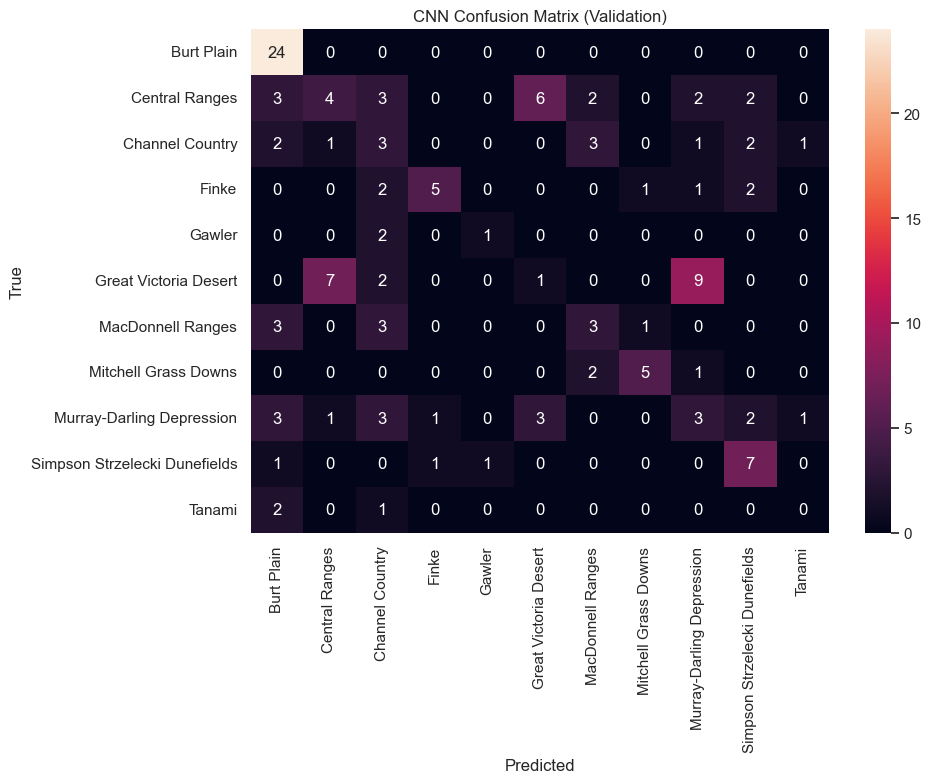

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_confusion_matrix_val.png


In [202]:
#  STEP 14 — Per-Region Performance (Class-wise metrics)

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

# Use validation to report unbiased performance
val_probs = model_cnn.predict(val_gen, verbose=0)
val_pred  = val_probs.argmax(axis=1)
val_true  = val_gen.classes
labels    = list(class_indices.keys())

# Classification report (per-class precision/recall/F1)
report_dict = classification_report(val_true, val_pred, target_names=labels, output_dict=True, digits=3)
df_report = pd.DataFrame(report_dict).T
perf_csv = os.path.join(out_dir, "cnn_per_region_performance.csv")
df_report.to_csv(perf_csv)
print("Saved per-region metrics ->", perf_csv)
display(df_report)

# Confusion matrix (validation)
cm = confusion_matrix(val_true, val_pred, labels=range(len(labels)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("CNN Confusion Matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
cm_path = os.path.join(out_dir, "cnn_confusion_matrix_val.png")
plt.savefig(cm_path, dpi=250); plt.show()
print("Saved:", cm_path)


ECE (validation): 0.1516


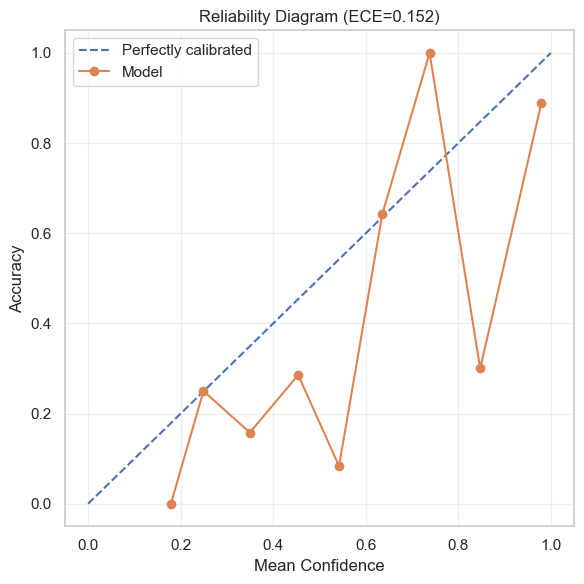

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_reliability_curve_val.png


In [204]:
# STEP 15 — Calibration (Reliability Curve and ECE)

import numpy as np
import matplotlib.pyplot as plt
import os

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

# Use validation predictions from Step 14
probs = val_probs                      # shape (N, C)
y_true = val_true                      # ints
y_pred = val_pred

# Top-1 confidence & correctness
conf = probs.max(axis=1)
correct = (y_pred == y_true).astype(np.float32)

# Reliability diagram bins
bins = np.linspace(0.0, 1.0, 11)  # 10 bins
bin_ids = np.digitize(conf, bins) - 1
acc_per_bin = []
conf_per_bin = []
counts = []
for b in range(10):
    mask = bin_ids == b
    if np.any(mask):
        acc_per_bin.append(correct[mask].mean())
        conf_per_bin.append(conf[mask].mean())
        counts.append(mask.sum())
    else:
        acc_per_bin.append(np.nan)
        conf_per_bin.append(np.nan)
        counts.append(0)

# Expected Calibration Error (ECE)
ece = 0.0
N = len(conf)
for b in range(10):
    if counts[b] > 0:
        ece += (counts[b]/N) * abs(acc_per_bin[b] - conf_per_bin[b])

print(f"ECE (validation): {ece:.4f}")

# Plot reliability curve
plt.figure(figsize=(6,6))

plt.plot([0,1], [0,1], linestyle="--", label="Perfectly calibrated")

mask = ~np.isnan(acc_per_bin)
plt.plot(np.array(conf_per_bin)[mask], np.array(acc_per_bin)[mask], marker="o", label="Model")
plt.title(f"Reliability Diagram (ECE={ece:.3f})")
plt.xlabel("Mean Confidence")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
cal_path = os.path.join(out_dir, "cnn_reliability_curve_val.png")
plt.tight_layout(); plt.savefig(cal_path, dpi=250); plt.show()
print("Saved:", cal_path)


In [206]:
# upgrade
!pip install --upgrade --quiet scikit-learn umap-learn


Total images for features: 698
Using penultimate layer: penultimate_dense
Feature matrix shape: (698, 128)
Saved features -> C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_penultimate_features_all.csv
UMAP failed, falling back to t-SNE. Reason: check_array() got an unexpected keyword argument 'ensure_all_finite'


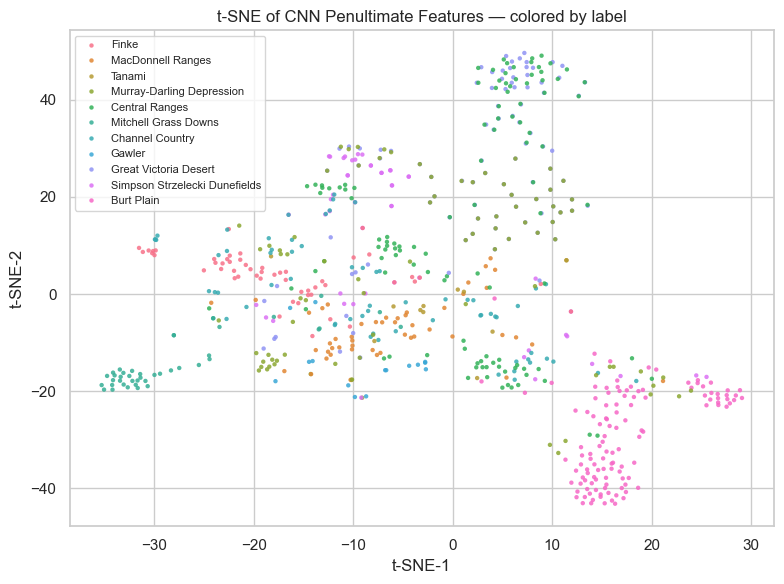

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\embedding_t-sne_by_label.png


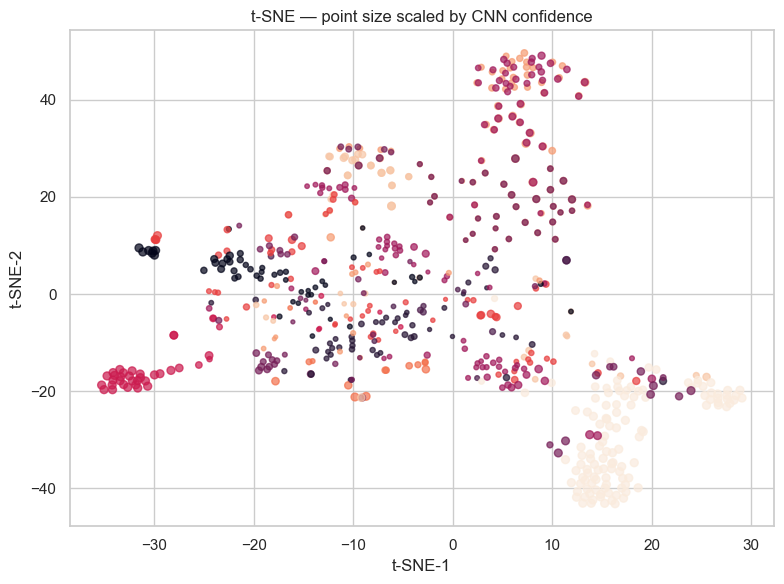

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\embedding_t-sne_conf_scaled.png
Saved UMAP embeddings to umap_embeddings.csv


In [208]:

# Step 16 — UMAP on CNN Features

import os, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


# !pip install umap-learn

import umap
import tensorflow as tf

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

# Safety checks on paths 
if "spec_fullpath" not in df_img.columns:
    raise ValueError("spec_fullpath column missing. Make sure earlier steps built absolute spectrogram paths.")

df_img_exist = df_img[df_img["spec_fullpath"].apply(os.path.isfile)].copy()
if df_img_exist.empty:
    raise ValueError("No spectrogram files found at listed paths in spec_fullpath. Double-check your spectrogram directory.")

print(f"Total images for features: {len(df_img_exist)}")

# Pick penultimate (Dense 128) layer output
# Our CNN: [Conv,MP,Conv,MP,Conv,MP,Flatten,Dense(128),Dropout,Dense(n_classes)]
# We want the Dense(128) BEFORE final Dense. That's layers[-3].
try:
    penult_layer = model_cnn.layers[-3]  # should be Dense(128)
    assert isinstance(penult_layer, tf.keras.layers.Dense)
    penult_name = penult_layer.name
except Exception:
    # Fallback: find last Dense before final Dense
    dense_layers = [l for l in model_cnn.layers if isinstance(l, tf.keras.layers.Dense)]
    if len(dense_layers) >= 2:
        penult_name = dense_layers[-2].name
    else:
        # last resort: take the layer just before final classification layer
        penult_name = model_cnn.layers[-2].name

print("Using penultimate layer:", penult_name)

feature_extractor = tf.keras.Model(
    inputs=model_cnn.input,
    outputs=model_cnn.get_layer(penult_name).output
)

# Image loader (match training: 128x128 RGB, rescale 1/255)
def load_img_as_array(path, target=(128,128)):
    im = Image.open(path).convert("RGB").resize(target)
    arr = np.asarray(im, dtype=np.float32) / 255.0
    return arr

# Extract features in batches (robust to tensorflow)
BATCH = 64
paths = df_img_exist["spec_fullpath"].tolist()
features_list = []

for i in range(0, len(paths), BATCH):
    batch_paths = paths[i:i+BATCH]
    Xb = np.stack([load_img_as_array(p) for p in batch_paths], axis=0)  # (B,128,128,3)
    Fb = feature_extractor.predict(Xb, verbose=0)                       # (B,128)
    features_list.append(Fb)

features = np.vstack(features_list)  # (N, 128)
print("Feature matrix shape:", features.shape)

# Save features for later steps
feat_path = os.path.join(out_dir, "cnn_penultimate_features_all.csv")
df_feat = pd.DataFrame(features, columns=[f"feat_{i}" for i in range(features.shape[1])])
# attach labels/preds
if "label" in df_img_exist.columns:
    df_feat["label"] = df_img_exist["label"].values
if "cnn_pred" in df_img_exist.columns:
    df_feat["cnn_pred"] = df_img_exist["cnn_pred"].values
if "cnn_conf" in df_img_exist.columns:
    df_feat["cnn_conf"] = df_img_exist["cnn_conf"].values
df_feat.to_csv(feat_path, index=False)
print("Saved features ->", feat_path)

# Embedding to 2D (UMAP with safe fallback to t-SNE)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# features: (N, 128) from previous cell
X_embed_in = np.asarray(features, dtype=np.float32, order="C")

use_umap = True
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
    emb2d = reducer.fit_transform(X_embed_in)
    method_name = "UMAP"
except Exception as e:
    print("UMAP failed, falling back to t-SNE. Reason:", e)
    from sklearn.manifold import TSNE
    emb2d = TSNE(
        n_components=2, perplexity=30, learning_rate="auto",
        init="random", random_state=42
    ).fit_transform(X_embed_in)
    method_name = "t-SNE"

# Attach and plot
df_umap = df_img_exist.copy()
df_umap["umap_x"] = emb2d[:,0]
df_umap["umap_y"] = emb2d[:,1]
color_col = "label" if "label" in df_umap.columns else "cnn_pred"

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_umap, x="umap_x", y="umap_y",
    hue=color_col, s=10, alpha=0.85, linewidth=0
)
plt.title(f"{method_name} of CNN Penultimate Features — colored by {color_col}")
plt.xlabel(f"{method_name}-1"); plt.ylabel(f"{method_name}-2")
plt.legend(loc="best", fontsize=8)
plt.tight_layout()t-
embed_path = os.path.join(out_dir, f"embedding_{method_name.lower()}_by_{color_col}.png")
plt.savefig(embed_path, dpi=250); plt.show()
print("Saved:", embed_path)

# size by confidence
if "cnn_conf" in df_umap.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(df_umap["umap_x"], df_umap["umap_y"],
                s=30*(df_umap["cnn_conf"].values+0.1),
                c=pd.factorize(df_umap[color_col])[0],
                alpha=0.7)
    plt.title(f"{method_name} — point size scaled by CNN confidence")
    plt.xlabel(f"{method_name}-1"); plt.ylabel(f"{method_name}-2")
    cpath = os.path.join(out_dir, f"embedding_{method_name.lower()}_conf_scaled.png")
    plt.tight_layout(); plt.savefig(cpath, dpi=250); plt.show()
    print("Saved:", cpath)

# Save UMAP embeddings to CSV

df_umap.to_csv("umap_embeddings.csv", index=False)
print("Saved UMAP embeddings to umap_embeddings.csv")


Saved per-class metrics -> C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_per_class_metrics.csv


,precision,recall,f1-score,support
Burt Plain,0.631579,1.000000,0.774194,24.0
Central Ranges,0.307692,0.181818,0.228571,22.0
Channel Country,0.157895,0.230769,0.187500,13.0
Finke,0.714286,0.454545,0.555556,11.0
Gawler,0.500000,0.333333,0.400000,3.0
Great Victoria Desert,0.100000,0.052632,0.068966,19.0
MacDonnell Ranges,0.300000,0.300000,0.300000,10.0
Mitchell Grass Downs,0.714286,0.625000,0.666667,8.0
Murray-Darling Depression,0.176471,0.176471,0.176471,17.0
Simpson Strzelecki Dunefields,0.466667,0.700000,0.560000,10.0


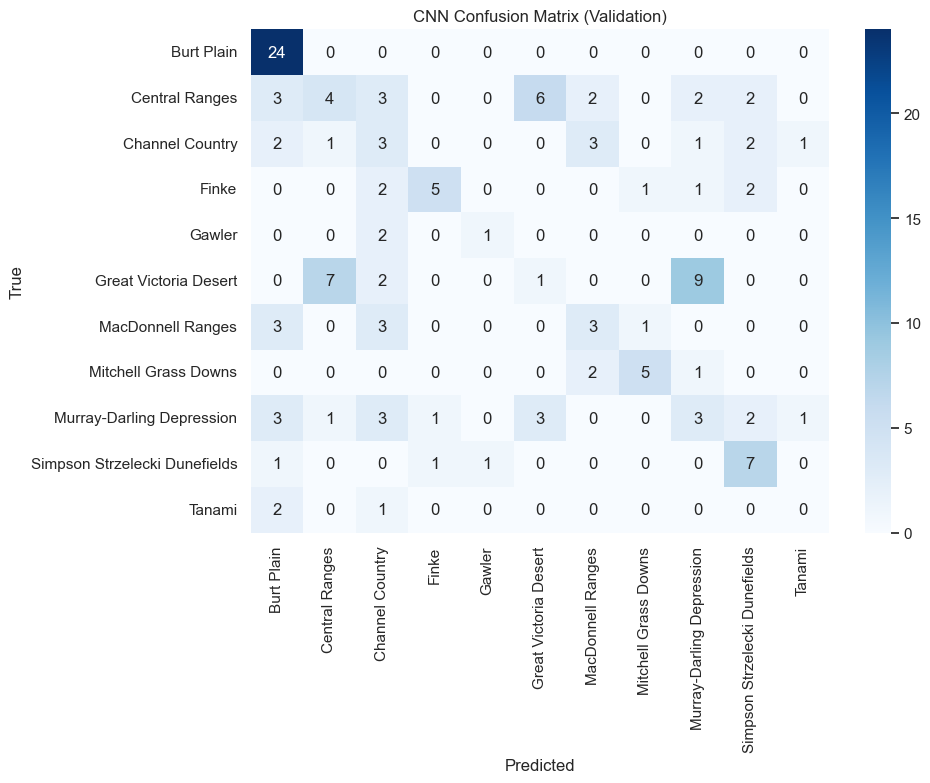

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_confusion_matrix_val.png


In [212]:

# Step 17 — Per-class Metrics & Confusion Matrix

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

# Ensure we have a validation generator and class_indices
from tensorflow.keras.preprocessing.image import ImageDataGenerator

need_rebuild = False
try:
    _ = val_gen.class_indices
    class_indices = val_gen.class_indices
except:
    need_rebuild = True

if need_rebuild:
    # Rebuild train/val from df_img (80/20) with same target size & rescale=1/255
    df_img_exist = df_img[df_img["spec_fullpath"].apply(os.path.isfile)].copy()
    # use ibra_bioregion as label column 
    if "label" not in df_img_exist.columns:
        if "ibra_bioregion" in df_img_exist.columns:
            df_img_exist["label"] = df_img_exist["ibra_bioregion"].astype(str)
        else:
            raise ValueError("No 'label' or 'ibra_bioregion' column found to use as class label.")

    # stratified split by label
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(
        df_img_exist, test_size=0.2, random_state=42, stratify=df_img_exist["label"]
    )

    datagen = ImageDataGenerator(rescale=1./255)
    train_gen = datagen.flow_from_dataframe(
        train_df, x_col="spec_fullpath", y_col="label",
        target_size=(128,128), color_mode="rgb",
        class_mode="categorical", batch_size=32, shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col="spec_fullpath", y_col="label",
        target_size=(128,128), color_mode="rgb",
        class_mode="categorical", batch_size=32, shuffle=False
    )
    class_indices = train_gen.class_indices

# validation predictions from the trained CNN
val_probs = model_cnn.predict(val_gen, verbose=0)
val_pred  = val_probs.argmax(axis=1)
val_true  = val_gen.classes
labels    = [k for k,_ in sorted(class_indices.items(), key=lambda x: x[1])]

# Classification report
report = classification_report(val_true, val_pred, target_names=labels, digits=3, output_dict=True)
df_report = pd.DataFrame(report).T
df_report_path = os.path.join(out_dir, "cnn_per_class_metrics.csv")
df_report.to_csv(df_report_path)
print("Saved per-class metrics ->", df_report_path)
display(df_report)

# Confusion matrix
cm = confusion_matrix(val_true, val_pred, labels=range(len(labels)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("CNN Confusion Matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
cm_path = os.path.join(out_dir, "cnn_confusion_matrix_val.png")
plt.savefig(cm_path, dpi=250)
plt.show()
print("Saved:", cm_path)


In [214]:
# 17B. PCA + K-means clustering (with model selection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=min(20, features.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Save PCA for later steps
np.save(os.path.join(out_dir, "pca_features.npy"), X_pca)
pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_var"]).to_csv(
    os.path.join(out_dir, "pca_explained_variance.csv"), index_label="PC"
)

# Choose K via silhouette
Ks = list(range(2, 13))
sil_scores, inertias = [], []
for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_k = km.fit_predict(X_pca[:, :10])   # use first 10 PCs
    inertias.append(km.inertia_)
    sil = silhouette_score(X_pca[:, :10], labels_k)
    sil_scores.append(sil)

sel_df = pd.DataFrame({"k": Ks, "silhouette": sil_scores, "inertia": inertias})
sel_df.to_csv(os.path.join(out_dir, "k_selection.csv"), index=False)

# Pick k = argmax silhouette
best_k = int(sel_df.iloc[sel_df["silhouette"].idxmax()]["k"])
print(f"[KMeans] Best k by silhouette: {best_k}")

# Final KMeans 
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
km_labels = kmeans.fit_predict(X_pca[:, :10])

# Attach to metadata
df_clusters = df_img.copy()
df_clusters["cluster_km"] = km_labels
df_clusters.to_csv(os.path.join(out_dir, "clusters_kmeans_assignments.csv"), index=False)

# Plot K-selection curves
plt.figure(figsize=(8,4)); plt.plot(Ks, sil_scores, marker="o"); plt.title("Silhouette vs k"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(out_dir,"k_silhouette.png"), dpi=300); plt.close()

plt.figure(figsize=(8,4)); plt.plot(Ks, inertias, marker="o"); plt.title("Inertia vs k"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(out_dir,"k_inertia.png"), dpi=300); plt.close()

print("[OK] Saved K-selection plots and assignments.")

[KMeans] Best k by silhouette: 3
[OK] Saved K-selection plots and assignments.


[OK] HDBSCAN completed; saved C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\clusters_hdbscan_assignments.csv


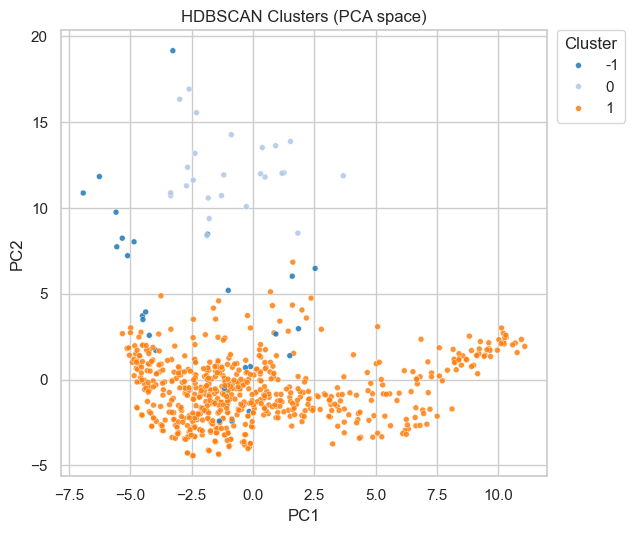

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\clusters_hdbscan_pca.png


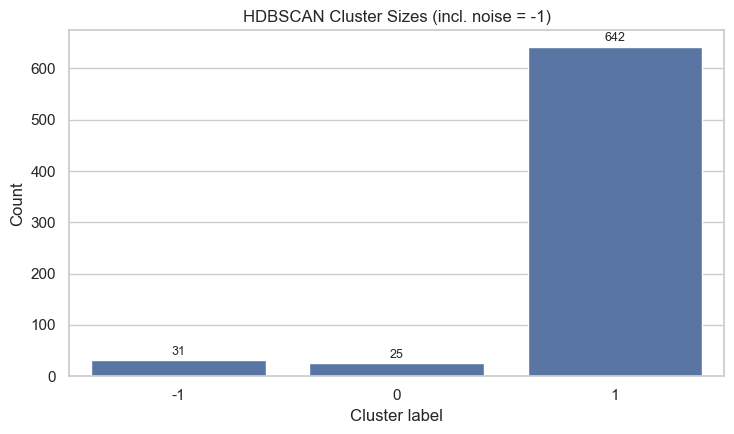

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\clusters_hdbscan_sizes.png


In [218]:
# 17C. HDBSCAN clustering 

hdb_labels = None
try:
    import hdbscan

    # Fit HDBSCAN on the same PCA space 
    clusterer = hdbscan.HDBSCAN(min_cluster_size=12, min_samples=5, metric="euclidean")
    hdb_labels = clusterer.fit_predict(X_pca[:, :10])   # labels include -1 for noise

    # Save assignments table 
    df_clusters["cluster_hdb"] = hdb_labels
    if hasattr(clusterer, "probabilities_"):
        df_clusters["hdb_prob"] = clusterer.probabilities_  # membership strength [0..1]
    out_csv = os.path.join(out_dir, "clusters_hdbscan_assignments.csv")
    df_clusters.to_csv(out_csv, index=False)
    print("[OK] HDBSCAN completed; saved", out_csv)

    # Figure 1: HDBSCAN clusters in PCA (2D)
    # Build a plotting frame with PC1/PC2 for visualization only
    df_hdb_plot = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "cluster_hdb": hdb_labels
    })
    if hasattr(clusterer, "probabilities_"):
        df_hdb_plot["prob"] = clusterer.probabilities_
    else:
        df_hdb_plot["prob"] = 1.0

    plt.figure(figsize=(6.5, 5.5))
    ax = sns.scatterplot(
        data=df_hdb_plot,
        x="PC1", y="PC2",
        hue="cluster_hdb",
        palette="tab20",
        s=18,
        alpha=0.85
    )
    ax.set_title("HDBSCAN Clusters (PCA space)")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

    # Move legend to the right
    plt.gcf().subplots_adjust(right=0.78)
    ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    fig_pca = os.path.join(out_dir, "clusters_hdbscan_pca.png")
    plt.tight_layout(); plt.savefig(fig_pca, dpi=250); plt.show()
    print("Saved:", fig_pca)

    # Figure 2: Cluster sizes (including noise = -1)
    size_series = pd.Series(hdb_labels).value_counts().sort_index()
    size_df = size_series.reset_index()
    size_df.columns = ["cluster_hdb", "count"]

    plt.figure(figsize=(7.5, 4.5))
    ax2 = sns.barplot(data=size_df, x="cluster_hdb", y="count")
    ax2.set_title("HDBSCAN Cluster Sizes (incl. noise = -1)")
    ax2.set_xlabel("Cluster label"); ax2.set_ylabel("Count")
    for p in ax2.patches:
        ax2.annotate(f"{int(p.get_height())}",
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha="center", va="bottom", fontsize=9, xytext=(0, 2),
                     textcoords="offset points")
    fig_sizes = os.path.join(out_dir, "clusters_hdbscan_sizes.png")
    plt.tight_layout(); plt.savefig(fig_sizes, dpi=250); plt.show()
    print("Saved:", fig_sizes)

except Exception as e:
    print("[INFO] HDBSCAN not run (package missing or error):", repr(e))
    print("       → This step is optional; KMeans results are available.")


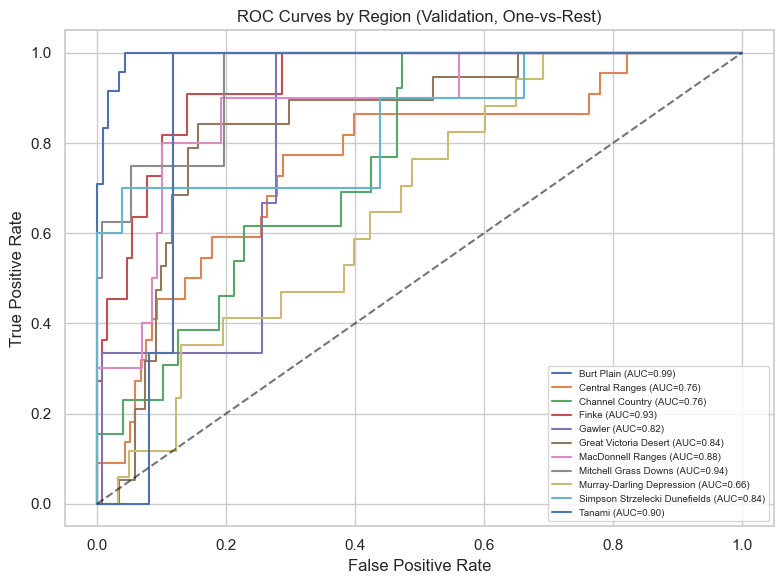

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\cnn_roc_curves_per_region.png


In [223]:
# Step 18 — Per-region ROC curves (one-vs-rest)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true = val_true
y_score = val_probs
n_classes = len(labels)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))
for i, lbl in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lbl} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.title("ROC Curves by Region (Validation, One-vs-Rest)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
roc_path = os.path.join(out_dir, "cnn_roc_curves_per_region.png")
plt.savefig(roc_path, dpi=250)
plt.show()
print("Saved:", roc_path)


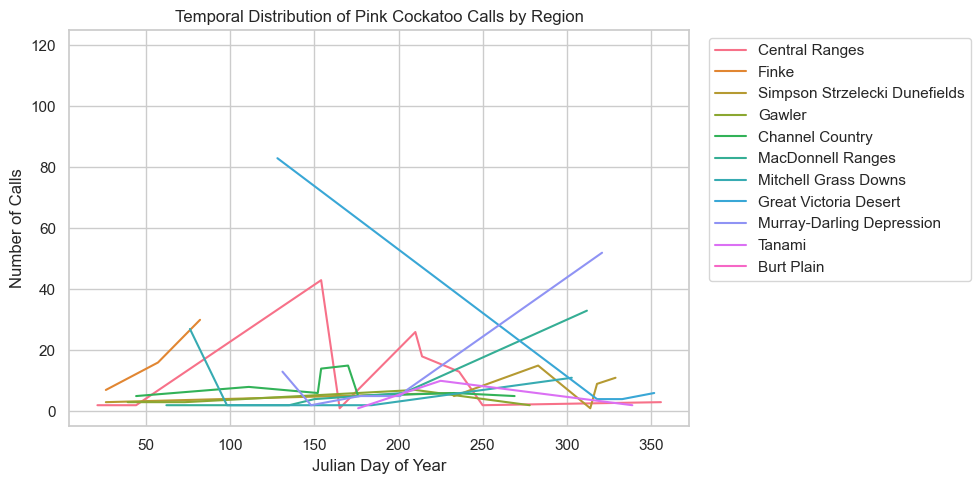

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\temporal_calls_by_region.png


In [225]:
# STEP 20 — Temporal Trends (date and time_local)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

tmp = df.copy()

# Build datetime from 'date' + 'time_local'
tmp["__combined_dt"] = pd.to_datetime(
    tmp["date"].astype(str) + " " + tmp["time_local"].astype(str),
    errors="coerce", dayfirst=True
)

# Derive julian_day (1 to 365/366 days)
tmp["julian_day"] = tmp["__combined_dt"].dt.dayofyear

# Ensure label exists (use ibra_bioregion if 'label' missing)
if "label" not in tmp.columns:
    if "ibra_bioregion" in tmp.columns:
        tmp["label"] = tmp["ibra_bioregion"].astype(str)
    else:
        raise KeyError("No 'label' or 'ibra_bioregion' column found for regions.")


counts = tmp.dropna(subset=["julian_day"]).groupby(["julian_day","label"]).size().reset_index(name="count")

# Plotting
plt.figure(figsize=(10,5))
sns.lineplot(data=counts, x="julian_day", y="count", hue="label")
plt.title("Temporal Distribution of Pink Cockatoo Calls by Region")
plt.xlabel("Julian Day of Year")
plt.ylabel("Number of Calls")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()

temporal_path = os.path.join(out_dir, "temporal_calls_by_region.png")
plt.savefig(temporal_path, dpi=250)
plt.show()

print("Saved:", temporal_path)


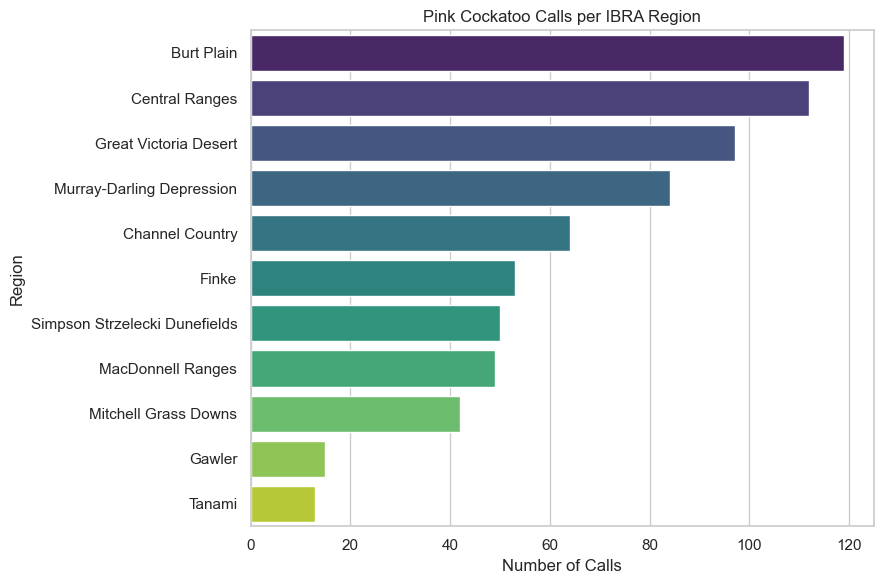

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\counts_by_region.csv and C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\call_counts_by_region.png


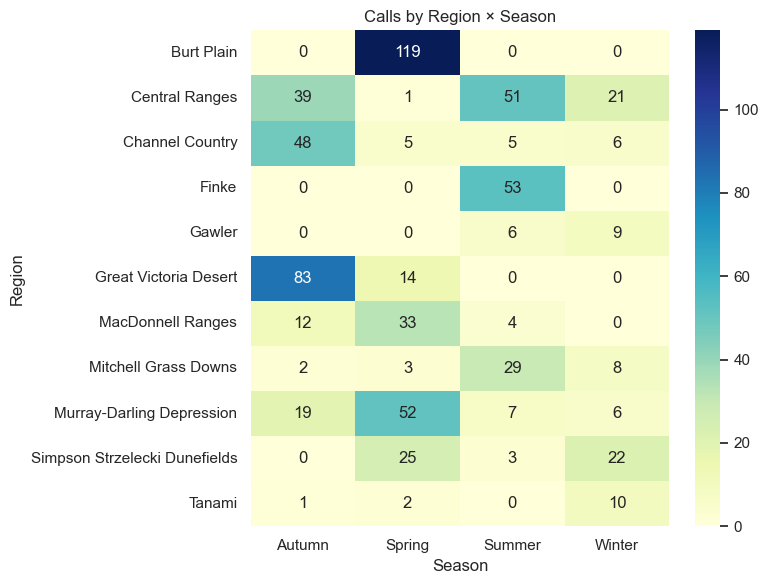

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\calls_region_by_season_heatmap.png


In [227]:
# Step 21 — Spatial summaries (by IBRA region) + season overlay

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

out_dir = r"C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results"
os.makedirs(out_dir, exist_ok=True)

# Region counts
region_counts = df["label"].value_counts().reset_index()
region_counts.columns = ["Region", "Num_Calls"]
region_counts_path = os.path.join(out_dir, "counts_by_region.csv")
region_counts.to_csv(region_counts_path, index=False)

plt.figure(figsize=(9,6))
sns.barplot(data=region_counts, x="Num_Calls", y="Region", palette="viridis")
plt.title("Pink Cockatoo Calls per IBRA Region")
plt.xlabel("Number of Calls"); plt.ylabel("Region")
plt.tight_layout()
fig_region_path = os.path.join(out_dir, "call_counts_by_region.png")
plt.savefig(fig_region_path, dpi=250); plt.show()
print("Saved:", region_counts_path, "and", fig_region_path)

# Region x Season heatmap 
if "season" in df.columns:
    region_season = df.pivot_table(index="label", columns="season", values="recording_id", aggfunc="count", fill_value=0)
    plt.figure(figsize=(8,6))
    sns.heatmap(region_season, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Calls by Region × Season")
    plt.xlabel("Season"); plt.ylabel("Region")
    plt.tight_layout()
    rs_path = os.path.join(out_dir, "calls_region_by_season_heatmap.png")
    plt.savefig(rs_path, dpi=250); plt.show()
    region_season.to_csv(os.path.join(out_dir, "calls_region_by_season.csv"))
    print("Saved:", rs_path)
else:
    print("Column 'season' not found — skipping region×season heatmap.")


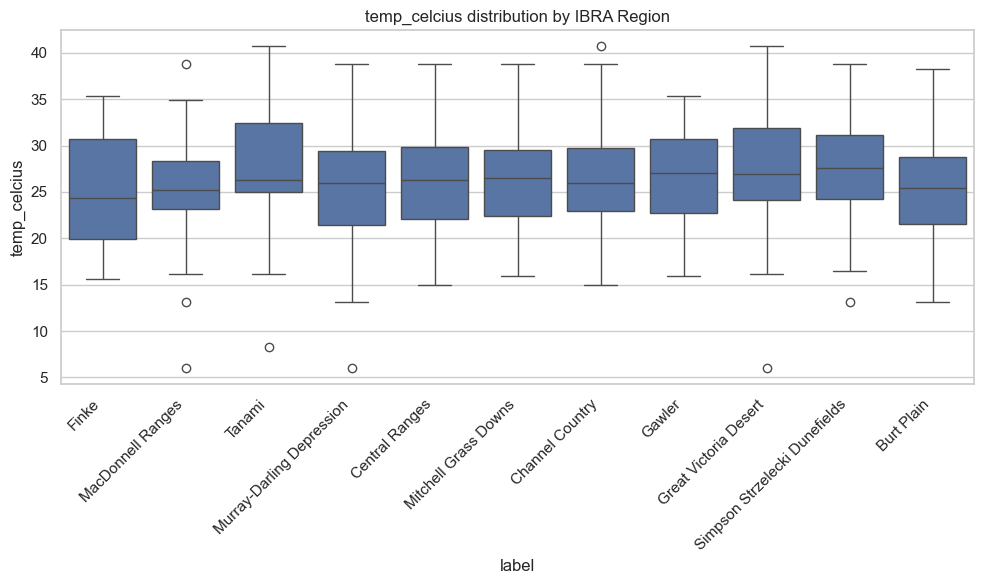

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\temp_celcius_by_region_boxplot.png


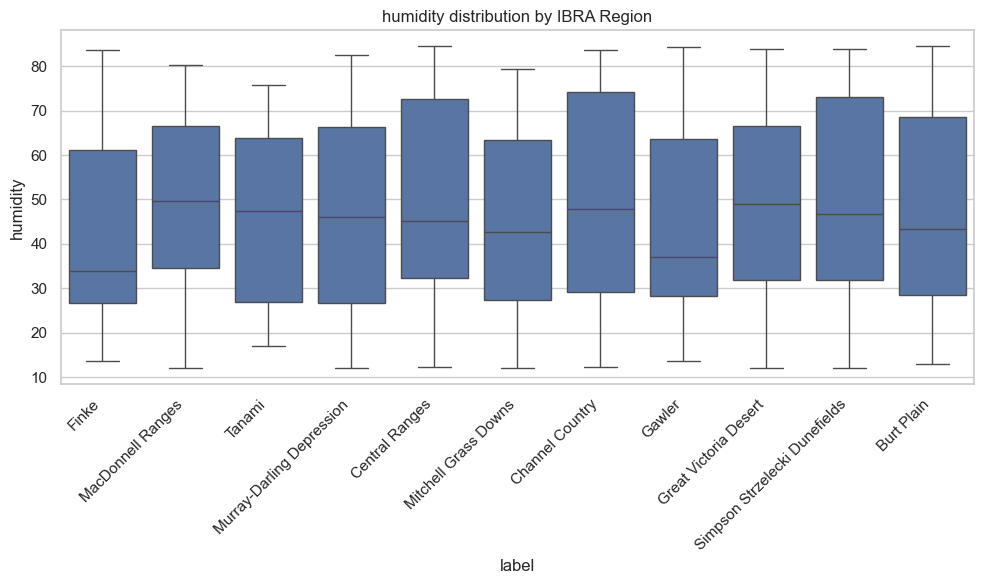

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\humidity_by_region_boxplot.png


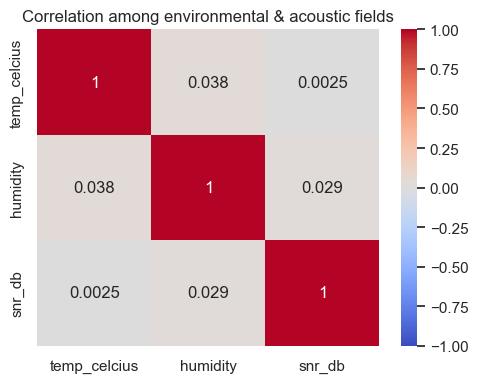

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\env_acoustic_correlation_heatmap.png


In [229]:
# Step 22 — Environmental summaries (temperature & humidity)


import matplotlib.pyplot as plt, seaborn as sns, numpy as np, os

# Boxplots by region
env_cols = [c for c in ["temp_celcius", "humidity"] if c in df.columns]
for col in env_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x="label", y=col)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{col} distribution by IBRA Region")
    plt.tight_layout()
    pth = os.path.join(out_dir, f"{col}_by_region_boxplot.png")
    plt.savefig(pth, dpi=250); plt.show()
    print("Saved:", pth)

# Simple correlation heatmap (env + duration + snr)
corr_cols = [c for c in ["temp_celcius","humidity","duration_s","snr_db"] if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr(numeric_only=True)
    plt.figure(figsize=(5,4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation among environmental & acoustic fields")
    plt.tight_layout()
    ch_path = os.path.join(out_dir, "env_acoustic_correlation_heatmap.png")
    plt.savefig(ch_path, dpi=250); plt.show()
    print("Saved:", ch_path)


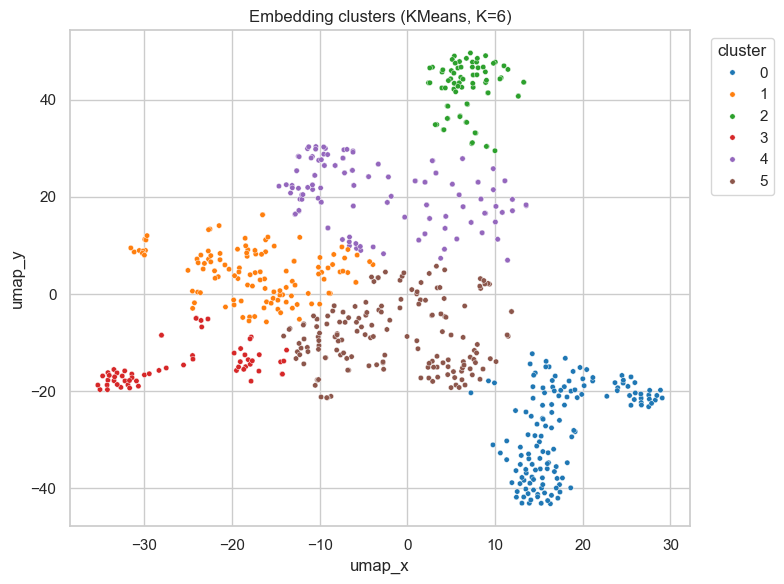

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\embedding_kmeans_K6.png


In [231]:
# STEP 23 — Kmeans Clustering on Embedding

from sklearn.cluster import KMeans

# coordinate names (we used 'umap_x'/'umap_y' earlier)
xcol = "UMAP1" if "UMAP1" in df_umap.columns else ("umap_x" if "umap_x" in df_umap.columns else None)
ycol = "UMAP2" if "UMAP2" in df_umap.columns else ("umap_y" if "umap_y" in df_umap.columns else None)
if xcol is None or ycol is None:
    raise ValueError("Embedding columns not found in df_umap. Expected UMAP1/UMAP2 or umap_x/umap_y.")

X2 = df_umap[[xcol, ycol]].values

# Choose a small K. this is exploratory (will adjust K if necessary)
K = 6
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_umap["embed_kmeans"] = kmeans.fit_predict(X2)

# Save cluster assignments
df_umap.to_csv(os.path.join(out_dir, "umap_with_kmeans_clusters.csv"), index=False)

# Plot embedding colored by k-means cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_umap, x=xcol, y=ycol, hue="embed_kmeans", palette="tab10", s=15)
plt.title(f"Embedding clusters (KMeans, K={K})")
plt.xlabel(xcol); plt.ylabel(ycol)
plt.legend(title="cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
cl_fig = os.path.join(out_dir, f"embedding_kmeans_K{K}.png")
plt.savefig(cl_fig, dpi=250); plt.show()
print("Saved:", cl_fig)


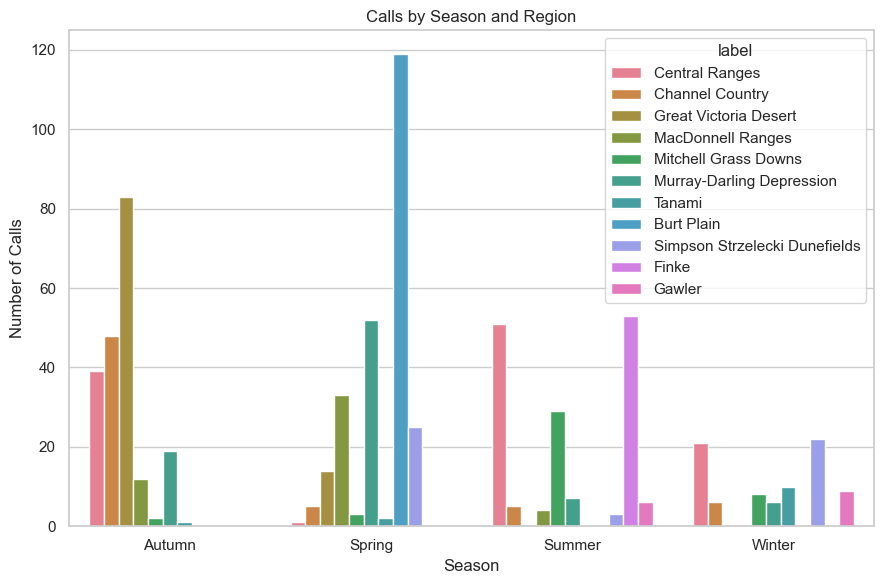

Saved: C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\seasonal_calls_by_region.png


In [233]:
# STEP 24 — Temporal & Seasonal Trends

import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os

# Seasonal trend (counts per season per region)
if "season" in df.columns:
    season_counts = df.groupby(["season","label"]).size().reset_index(name="count")
    plt.figure(figsize=(9,6))
    sns.barplot(data=season_counts, x="season", y="count", hue="label")
    plt.title("Calls by Season and Region")
    plt.xlabel("Season"); plt.ylabel("Number of Calls")
    plt.tight_layout()
    sc_path = os.path.join(out_dir, "seasonal_calls_by_region.png")
    plt.savefig(sc_path, dpi=250); plt.show()
    season_counts.to_csv(os.path.join(out_dir, "seasonal_calls_by_region.csv"), index=False)
    print("Saved:", sc_path)
else:
    print("Column 'season' not found — skipping seasonal bar chart.")


In [235]:
# STEP 25 — Export excel workbook

!pip install xlsxwriter


import pandas as pd, os

wb_path = os.path.join(out_dir, "thesis_outputs.xlsx")
with pd.ExcelWriter(wb_path, engine="xlsxwriter") as xw:
    # Embedding coordinates (with region + cluster)
    cols_to_keep = [c for c in [xcol, ycol, "label", "embed_kmeans", "cnn_conf", "cnn_pred"] if c in df_umap.columns]
    df_umap[cols_to_keep].to_excel(xw, sheet_name="embedding", index=False)
    # Region counts
    region_counts.to_excel(xw, sheet_name="counts_by_region", index=False)
    # Region x season
    if os.path.exists(os.path.join(out_dir, "calls_region_by_season.csv")):
        pd.read_csv(os.path.join(out_dir, "calls_region_by_season.csv")).to_excel(xw, sheet_name="region_by_season", index=False)
    # Seasonal counts
    if os.path.exists(os.path.join(out_dir, "seasonal_calls_by_region.csv")):
        pd.read_csv(os.path.join(out_dir, "seasonal_calls_by_region.csv")).to_excel(xw, sheet_name="seasonal_counts", index=False)
    # Summary stats
    summary = {
        "total_calls": int(len(df)),
        "unique_regions": int(df["label"].nunique()),
        "avg_duration_s": float(df["duration_s"].mean()) if "duration_s" in df.columns else None,
        "avg_snr_db": float(df["snr_db"].mean()) if "snr_db" in df.columns else None
    }
    pd.DataFrame([summary]).to_excel(xw, sheet_name="summary", index=False)

print("Saved Excel workbook ->", wb_path)


Saved Excel workbook -> C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\thesis_outputs.xlsx


In [237]:
# Step 26 — Result Index

import os, pandas as pd

produced = [
    "umap_embeddings.csv",
    "umap_with_kmeans_clusters.csv",
    "counts_by_region.csv",
    "calls_region_by_season.csv",
    "seasonal_calls_by_region.csv",
    "call_counts_by_region.png",
    "calls_region_by_season_heatmap.png",
    "seasonal_calls_by_region.png",
    "env_acoustic_correlation_heatmap.png",
    "temp_celcius_by_region_boxplot.png",
    "humidity_by_region_boxplot.png",
    "embedding_kmeans_K6.png",
    "thesis_outputs.xlsx"
]
existing = [os.path.join(out_dir, f) for f in produced if os.path.exists(os.path.join(out_dir, f))]

pd.Series(existing, name="Produced Files").to_csv(os.path.join(out_dir, "RESULTS_INDEX.csv"), index=False)
print("Wrote RESULTS_INDEX.csv with", len(existing), "paths.")
for p in existing:
    print("✔", p)


Wrote RESULTS_INDEX.csv with 12 paths.
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\umap_with_kmeans_clusters.csv
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\counts_by_region.csv
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\calls_region_by_season.csv
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\seasonal_calls_by_region.csv
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\call_counts_by_region.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\calls_region_by_season_heatmap.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\seasonal_calls_by_region.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\env_acoustic_correlation_heatmap.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\temp_celcius_by_region_boxplot.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\humidity_by_region_boxplot.png
✔ C:\Users\rahma\Downloads\AI-Driven Bioacoustics\results\embedding_kmeans_K6.png